# **Análisis Exploratorio de Datos (EDA)**

## **Librerías y modulos necesarios**


In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
from windrose import WindroseAxes
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from itertools import product
import warnings
warnings.filterwarnings("ignore")

## **Contextualización de los datos**

El conjunto de datos a tratar cuenta con información sobre variables climáticas esenciales capturadas en una región costera mediante un sistema de monitoreo atmosférico que comenzó a operar el **1 de enero de 2022**. Este sistema incluye anemómetros acústicos ubicados a 100 m, 80 m, 60 m y 40 m de altura para registrar la velocidad del viento, así como veletas que miden su dirección a esas mismas alturas. También dispone de sensores de temperatura a 100 m y 20 m, y sensores de presión atmosférica y humedad relativa. Las mediciones se toman a intervalos de **10 minutos**, permitiendo la captura de datos en alta frecuencia y con un alto grado de detalle. Gracias a esta estructura de monitoreo, el conjunto de datos proporciona una base sólida para desarrollar modelos predictivos y analizar el comportamiento del viento y sus variaciones en tiempo real, fundamentales para la gestión y optimización de recursos energéticos eólicos en la región de estudio.

## **Conjunto de datos**

In [236]:
file_path = r"C:\Users\kamac\OneDrive\Desktop\MachineLearningUN\EDA\DATA.xlsx"
data = pd.read_excel(file_path)

### **Características del conjunto de datos**

Inicialmente, se observan las primeras **5 observaciones** del conjunto de datos con el uso del método `.head()`

In [237]:
data.head()

SoftwareVersion  buildbuiltbyCIserver20210728  VarName3  VarName4  \
0  2022-01-01 00:00:00                     16.060860  0.958639  13.15692   
1  2022-01-01 00:10:00                     16.156927  0.885824  13.48116   
2  2022-01-01 00:20:00                     16.473571  0.911763  13.48116   
3  2022-01-01 00:30:00                     16.660009  0.860070  14.31492   
4  2022-01-01 00:40:00                     16.519613  0.903333  13.89804   

   VarName5   VarName6   VarName7  VarName8  VarName9  VarName10  ...  \
0  18.76164  18.468434  15.830104  0.959005  12.85460   18.23426  ...   
1  18.06684  17.850526  15.972642  0.891046  13.59028   18.41818  ...   
2  18.48372  18.298440  16.287375  0.914220  13.49832   18.37220  ...   
3  19.27116  18.931634  16.451707  0.842721  13.77420   18.69406  ...   
4  19.31748  18.561074  16.353678  0.889667  13.63626   19.15386  ...   

   VarName51  VarName52  VarName53  VarName54  VarName55  VarName56  \
0        0.0        0.0        0.0   0.000076      61.08       3.08   
1        0.0        0.0        0.0   0.000076      61.08       2.83   
2        0.0        0.0        0.0   0.000076      60.42       2.74   
3        0.0        0.0        0.0   0.000000      60.88       2.83   
4        0.0        0.0        0.0   0.000076      59.99       2.59   

   VarName57  VarName58  VarName59  VarName60  
0      143.8      61.21       3.39      143.8  
1      143.8      61.49       3.36      143.8  
2      143.8      60.65       3.11      143.8  
3      143.8      61.19       3.16      143.8  
4      143.8      60.26       3.21      143.8  

[5 rows x 60 columns]

Observamos que la mayoría de las variables en el conjunto de datos son de tipo numérico, con una excepción de tipo categórico. Además, los nombres de las columnas son poco descriptivos, lo cual dificulta su comprensión; por lo tanto, se plantea la posibilidad de renombrar las variables más adelante para mejorar la claridad del análisis.

In [238]:
data.shape

(38448, 60)

Al usar el método `.shape` observamos que el conjunto de datos contiene **60** variables y **38448** observaciones.

## **Reorganización del conjunto de datos**

Dado a la naturaleza de los datos previamente vista, se tomó la decisión de dividir y reorganizar la base de datos en subconjuntos correspondientes a distintas partes y características de esta; permitiendo así un mejor manejo de los datos a modelar. También se convierte la columna `SoftwareVersion` en formato de fecha utilizando datetime para facilitar el análisis temporal de los datos.

In [239]:
data.rename(columns = {'buildbuiltbyCIserver20210728': 'VarName2'}, inplace = True)
data['Fecha'] = pd.to_datetime(data['SoftwareVersion'])
subconjuntos = {
    'Wind speed 100 m (sensor 1)': ['VarName2', 'VarName3', 'VarName4', 'VarName5', 'VarName6'],
    'Wind speed 100 m (sensor 2)': ['VarName7', 'VarName8', 'VarName9', 'VarName10', 'VarName11'],
    'Wind speed 80 m (sensor 1)': ['VarName12', 'VarName13', 'VarName14', 'VarName15', 'VarName16'],
    'Wind speed 80 m (sensor 2)': ['VarName17', 'VarName18', 'VarName19', 'VarName20', 'VarName21'],
    'Wind speed 60 m': ['VarName22', 'VarName23', 'VarName24', 'VarName25', 'VarName26'],
    'Wind speed 40 m': ['VarName27', 'VarName28', 'VarName29', 'VarName30', 'VarName31'],
    'Wind direction 60 m': ['VarName32', 'VarName33', 'VarName34'],
    'Presión': ['VarName35', 'VarName36', 'VarName37', 'VarName38'],
    'Humedad': ['VarName39', 'VarName40', 'VarName41', 'VarName42'],
    'Temperatura 100 m': ['VarName43', 'VarName44', 'VarName45', 'VarName46'],
    'Temperatura 21 m': ['VarName47', 'VarName48', 'VarName49', 'VarName50'],
    'Canal vacío': ['VarName51', 'VarName52', 'VarName53', 'VarName54'],
    'Wind direction 100 m': ['VarName55', 'VarName56', 'VarName57'],
    'Wind direction 80 m': ['VarName58', 'VarName59', 'VarName60']
}


Así se verían los subconjuntos:



| **Variable**                   | **Wind speed 100 m (sensor 1)** | **Wind speed 100 m (sensor 2)** | **Wind speed 80 m (sensor 1)** | **Wind speed 80 m (sensor 2)** | **Wind speed 60 m** | **Wind speed 40 m** | **Wind direction 60 m** | **Wind direction 100 m** | **Wind direction 80 m** | **Presión** | **Humedad** | **Temperature 100 m** | **Temperature 21 m** | **Canal vacío** |
|--------------------------------|---------------------------------|---------------------------------|---------------------------------|---------------------------------|-----------------------|-----------------------|--------------------------|--------------------------|--------------------------|--------------|-------------|------------------------|-----------------------|-----------------|
| **1. Promedio (AVG)**          | VarName2                        | VarName7                        | VarName12                       | VarName17                       | VarName22            | VarName27            | VarName32                | VarName55                | VarName58                | VarName35    | VarName39   | VarName43              | VarName47             | VarName51       |
| **2. Desviación Estándar (SD)** | VarName3                        | VarName8                        | VarName13                       | VarName18                       | VarName23            | VarName28            | VarName33                | VarName56                | VarName59                | VarName36    | VarName40   | VarName44              | VarName48             | VarName52       |
| **3. Valor Mínimo (Min)**       | VarName4                        | VarName9                        | VarName14                       | VarName19                       | VarName24            | VarName29            |                          |                          |                          | VarName37    | VarName41   | VarName45              | VarName49             | VarName53       |
| **4. Valor Máximo (Max)**       | VarName5                        | VarName10                       | VarName15                       | VarName20                       | VarName25            | VarName30            |                          |                          |                          | VarName38    | VarName42   | VarName46              | VarName50             | VarName54       |
| **5. Ráfaga Máxima (Gust)**     | VarName6                        | VarName11                       | VarName16                       | VarName21                       | VarName26            | VarName31            | VarName34                | VarName57                | VarName60                |              |             |                        |                       |                 |



### **Reducción de Dimensionalidad**

Para simplificar el análisis y reducir la dimensionalidad del conjunto de datos, se opta por conservar únicamente la variable de **promedio (AVG)** para cada medición. El promedio proporciona una medida representativa del comportamiento general de las variables (como velocidad del viento, temperatura, presión, etc.) en cada intervalo de 10 minutos. Además, se eliminará la variable de **Canal Vacío**, ya que esta columna no contiene información relevante o valores de medición que puedan aportar al análisis. Mantenerla solo añadiría ruido al conjunto de datos, complicando innecesariamente el procesamiento y análisis de las variables significativas.

No se aplicará el **Factor de Inflación de Varianza (VIF)**, ya que su uso podría eliminar de forma inconsistente diferentes estadísticas en cada variable, como el promedio en algunas y la desviación estándar en otras. Esto resultaría en un conjunto de datos inconsistente, donde las variables no tendrían el mismo tipo de estadístico representativo, lo cual dificultaría el análisis y la interpretación. Al mantener solo el promedio, se asegura que todas las variables posean un valor consistente y representativo, facilitando una interpretación coherente y un análisis robusto de las tendencias generales.

Entonces, contariamos con las siguientes variables: 

| **Variable**          | **Valor**    |
|-----------------------|--------------|
| **Wind speed 100 m (sensor 1)** | VarName2      |
| **Wind speed 100 m (sensor 2)** | VarName7      |
| **Wind speed 80 m (sensor 1)**   | VarName12     |
| **Wind speed 80 m (sensor 2)**   | VarName17     |
| **Wind speed 60 m**              | VarName22     |
| **Wind speed 40 m**              | VarName27     |
| **Wind direction 60 m**          | VarName32     |
| **Wind direction 100 m**         | VarName55     |
| **Wind direction 80 m**          | VarName58     |
| **Presión**                      | VarName35     |
| **Humedad**                      | VarName39     |
| **Temperature 100 m**            | VarName43     |
| **Temperature 21 m**             | VarName47     |



Ahora, filtramos el conjunto de datos para conservar únicamente las variables de interés:

In [240]:
variables = [
    'Fecha', 'VarName2', 'VarName7', 'VarName12', 'VarName17',
    'VarName22', 'VarName27', 'VarName32', 'VarName55', 'VarName58',
    'VarName35', 'VarName39', 'VarName43', 'VarName47'
]
data = data[variables]
data.head()

Fecha   VarName2   VarName7  VarName12  VarName17  VarName22  \
0 2022-01-01 00:00:00  16.060860  15.830104  15.145418  15.125038  14.300989   
1 2022-01-01 00:10:00  16.156927  15.972642  15.290614  15.352352  14.533556   
2 2022-01-01 00:20:00  16.473571  16.287375  15.599149  15.562022  14.808378   
3 2022-01-01 00:30:00  16.660009  16.451707  15.801446  15.779687  15.170287   
4 2022-01-01 00:40:00  16.519613  16.353678  15.851963  15.749131  14.927282   

   VarName27  VarName32  VarName55  VarName58    VarName35  VarName39  \
0  13.199266      61.98      61.08      61.21  1005.963541  75.042725   
1  13.511498      62.29      61.08      61.49  1005.795867  73.509216   
2  13.595550      61.18      60.42      60.65  1005.739976  72.914124   
3  14.082179      62.20      60.88      61.19  1005.684085  73.165894   
4  13.761358      61.26      59.99      60.26  1005.609563  73.791504   

   VarName43  VarName47  
0  26.922913  26.707773  
1  27.006836  26.772633  
2  26.991577  26.772633  
3  26.877136  26.659982  
4  26.770325  26.601949

### **Renombrado de variables**

A continuación, realizaremos un renombrado de variables en nuestro conjunto de datos para facilitar su identificación y comprensión. Este cambio permitirá que cada variable tenga un nombre más descriptivo, reflejando su contenido y las características específicas de las mediciones, lo cual facilitará el análisis y la interpretación de los datos en los siguientes pasos del proyecto.

In [241]:
data = data.rename(columns = {
    'Fecha': 'Fecha',
    'VarName2': 'VelViento100m_1',
    'VarName7': 'VelViento100m_2',
    'VarName12': 'VelViento80m_1',
    'VarName17': 'VelViento80m_2',
    'VarName22': 'VelViento60m',
    'VarName27': 'VelViento40m',
    'VarName32': 'DirViento60m',
    'VarName55': 'DirViento100m',
    'VarName58': 'DirViento80m',
    'VarName35': 'Presion',
    'VarName39': 'Humedad',
    'VarName43': 'Temp100m',
    'VarName47': 'Temp21m'
})


In [242]:
data.head()

Fecha  VelViento100m_1  VelViento100m_2  VelViento80m_1  \
0 2022-01-01 00:00:00        16.060860        15.830104       15.145418   
1 2022-01-01 00:10:00        16.156927        15.972642       15.290614   
2 2022-01-01 00:20:00        16.473571        16.287375       15.599149   
3 2022-01-01 00:30:00        16.660009        16.451707       15.801446   
4 2022-01-01 00:40:00        16.519613        16.353678       15.851963   

   VelViento80m_2  VelViento60m  VelViento40m  DirViento60m  DirViento100m  \
0       15.125038     14.300989     13.199266         61.98          61.08   
1       15.352352     14.533556     13.511498         62.29          61.08   
2       15.562022     14.808378     13.595550         61.18          60.42   
3       15.779687     15.170287     14.082179         62.20          60.88   
4       15.749131     14.927282     13.761358         61.26          59.99   

   DirViento80m      Presion    Humedad   Temp100m    Temp21m  
0         61.21  1005.963541  75.042725  26.922913  26.707773  
1         61.49  1005.795867  73.509216  27.006836  26.772633  
2         60.65  1005.739976  72.914124  26.991577  26.772633  
3         61.19  1005.684085  73.165894  26.877136  26.659982  
4         60.26  1005.609563  73.791504  26.770325  26.601949

Cada observación en el conjunto de datos representa el **promedio de las mediciones** tomadas durante un intervalo de 10 minutos para cada una de las variables monitoreadas. Estas incluyen la velocidad del viento a distintas alturas (40 m, 60 m, 80 m, y 100 m), la dirección del viento, la presión atmosférica, la humedad relativa y la temperatura en diferentes niveles. 

In [243]:
data.shape

(38448, 14)

Luego de la reorganización de variables, nos quedamos con un conjunto de datos de **38,448 observaciones y 14 variables**. Este conjunto de datos incluye las mediciones promedio tomadas cada 10 minutos para las variables seleccionadas, permitiendo un análisis más enfocado y manejable de las condiciones atmosféricas en la región de estudio.

### **Diccionario de variables**

| **Nombre**     | **Descripción**                                      | **Unidad de Medida** |
|----------------------|------------------------------------------------------|-----------------------|
| `Fecha`              | Fecha y hora de la medición                          | -                     |
| `VelViento100m_1`    | Velocidad del viento a 100 m (sensor 1)              | m/s                   |
| `VelViento100m_2`    | Velocidad del viento a 100 m (sensor 2)              | m/s                   |
| `VelViento80m_1`     | Velocidad del viento a 80 m (sensor 1)               | m/s                   |
| `VelViento80m_2`     | Velocidad del viento a 80 m (sensor 2)               | m/s                   |
| `VelViento60m`       | Velocidad del viento a 60 m                          | m/s                   |
| `VelViento40m`       | Velocidad del viento a 40 m                          | m/s                   |
| `DirViento60m`       | Dirección del viento a 60 m                          | Grados (°)            |
| `DirViento100m`      | Dirección del viento a 100 m                         | Grados (°)            |
| `DirViento80m`       | Dirección del viento a 80 m                          | Grados (°)            |
| `Presion`            | Presión atmosférica                                  | hPa                   |
| `Humedad`            | Humedad relativa                                     | %                     |
| `Temp100m`           | Temperatura a 100 m                                  | °C                    |
| `Temp21m`            | Temperatura a 21 m                                   | °C                    |



## **Datos faltantes**

En esta sección, se examina el porcentaje de valores faltantes en las principales variables seleccionadas del dataset. El análisis gráfico de los valores faltantes proporciona una visión clara de la magnitud y distribución de los datos faltantes en cada variable, permitiendo identificar posibles problemas de calidad de datos que podrían afectar el análisis.

In [244]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage.sort_values(ascending = False)

Fecha              0.0
VelViento100m_1    0.0
VelViento100m_2    0.0
VelViento80m_1     0.0
VelViento80m_2     0.0
VelViento60m       0.0
VelViento40m       0.0
DirViento60m       0.0
DirViento100m      0.0
DirViento80m       0.0
Presion            0.0
Humedad            0.0
Temp100m           0.0
Temp21m            0.0
dtype: float64

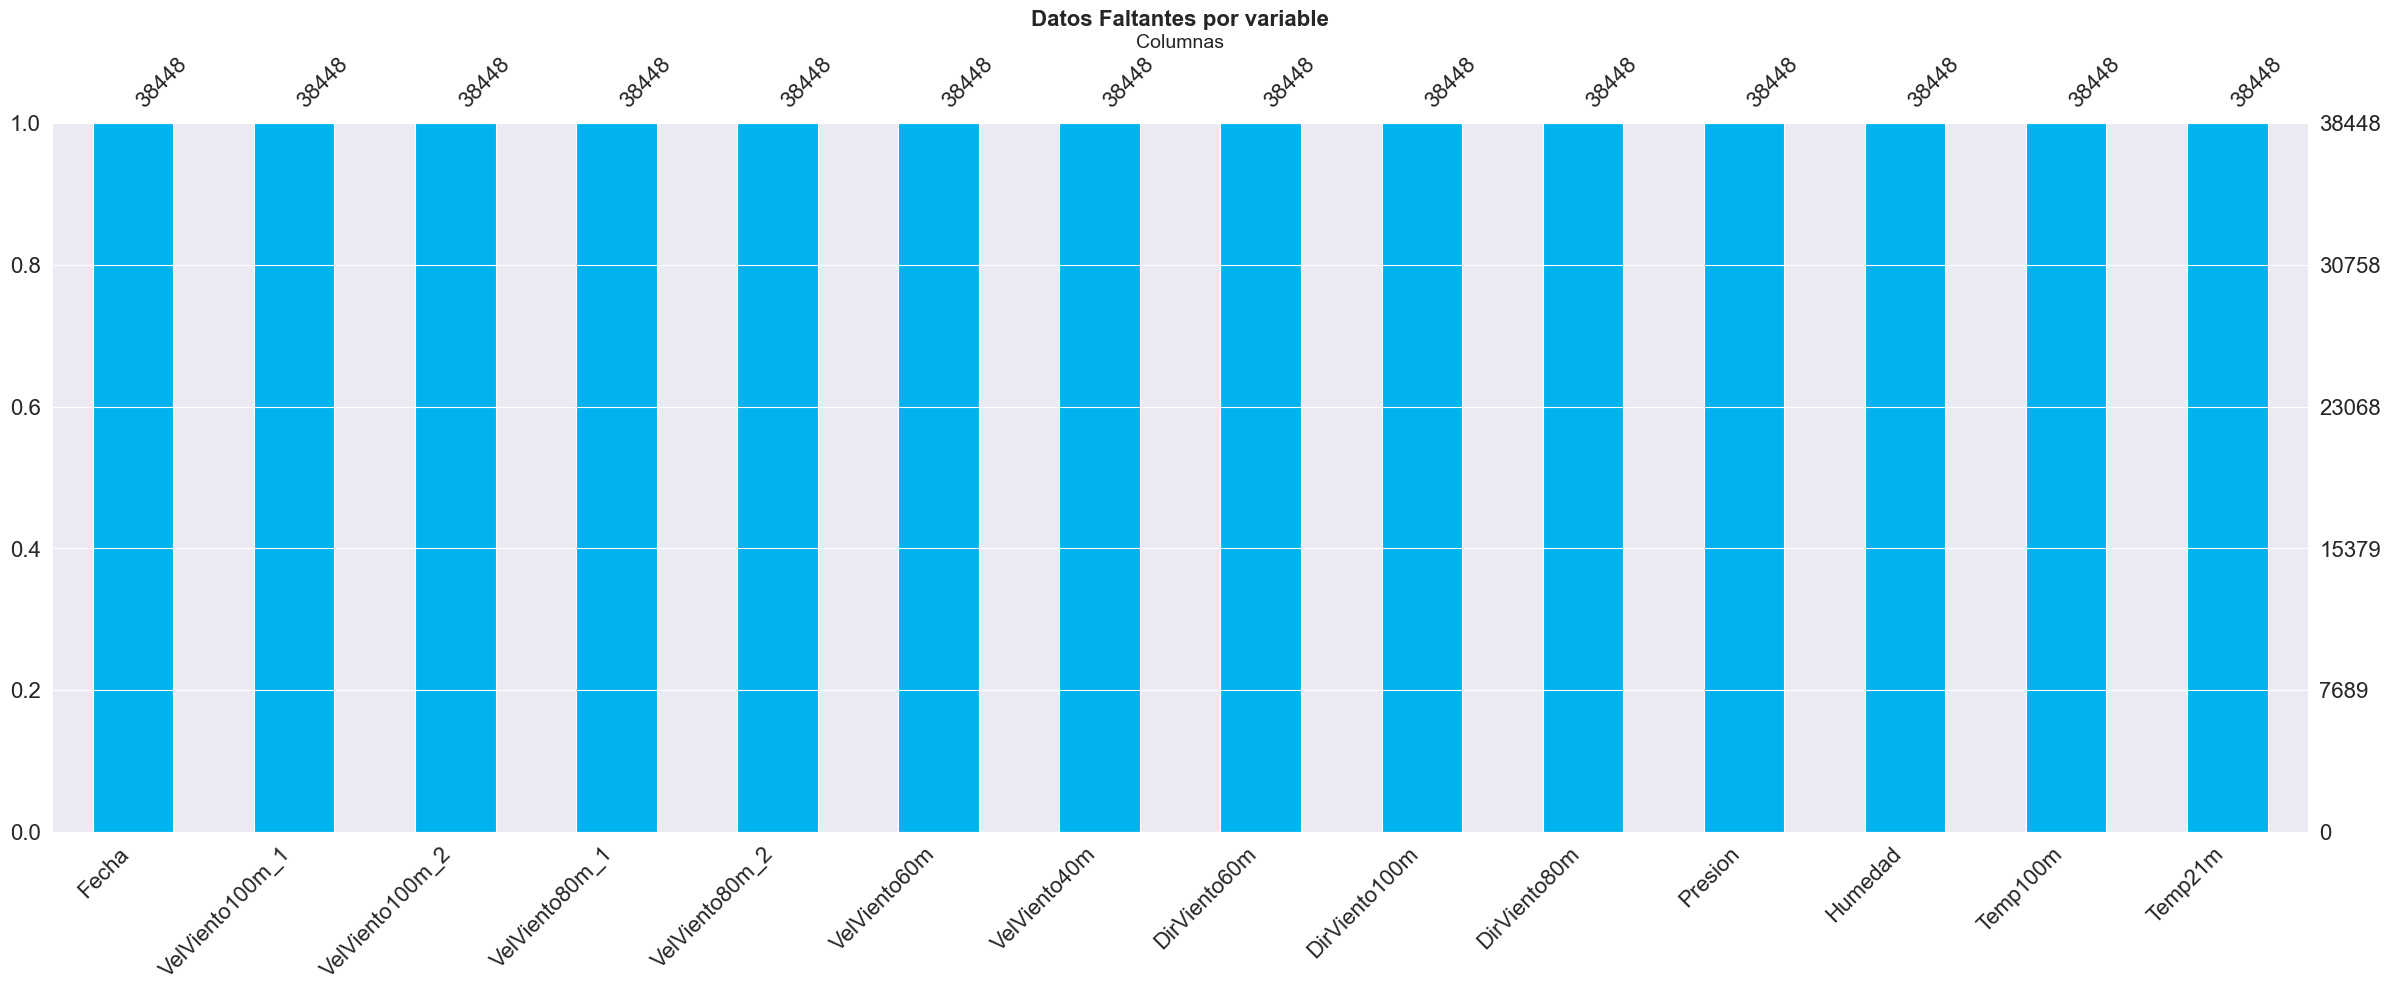

In [245]:
msno.bar(data, color = "#00B2EE", sort = 'ascending')
plt.title('Datos Faltantes por variable', fontsize = 16, fontweight = 'bold')
plt.xlabel('Columnas', fontsize = 14)
plt.ylabel('Porcentaje de Datos Faltantes', fontsize = 14)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

### **Reporte de fallas de sensores**

In [246]:
# Supongamos que 'data' es tu DataFrame y 'Fecha' es la columna de fechas
data['Fecha'] = pd.to_datetime(data['Fecha'])

# 1. Periodo de registros completos desde el 21 de diciembre de 2021 hasta el 17 de mayo a las 9:30 pm
# No hay cambios para este periodo

# 2. Del 17 de mayo a las 9:30 pm hasta el 1 de junio a las 12:40 pm
# Se registran solo las variables de velocidad del viento a 40 m y dirección del viento a 60 m y 80 m
data.loc[(data['Fecha'] > '2022-05-17 21:30:00') & (data['Fecha'] <= '2022-06-01 12:40:00'), 
         ['VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 
          'VelViento60m', 'DirViento100m', 'Temp100m', 'Temp21m', 'Humedad', 'Presion']] = np.nan

# 3. Del 1 de junio a las 12:40 pm en adelante
# Se registran solo las variables de velocidad del viento a 60 m y 80 m (Sensor 1)
data.loc[(data['Fecha'] > '2022-06-01 12:40:00') & (data['Fecha'] < '2022-08-05 05:20:00'), 
         ['VelViento100m_1', 'VelViento100m_2','VelViento80m_2' ,'DirViento100m', 'Temp100m', 'Humedad']] = np.nan

# 4. A partir del 5 de agosto a las 5:20 am
# Se pierden los datos de velocidad del viento a 60 m y 80 m, dirección del viento a 100 m, temperatura a 100 m y humedad
data.loc[data['Fecha'] >= '2022-08-05 05:20:00', 
         ['VelViento60m', 'VelViento80m_1', 'VelViento80m_2', 'DirViento100m', 'Temp100m', 'Humedad']] = np.nan

# 5. Desde el 5 de agosto en adelante, quedan solo los datos de velocidad del viento a 40 m, dirección del viento a 60 m, temperatura a 20 m y presión atmosférica
data.loc[data['Fecha'] >= '2022-08-05 05:20:00', 
         ['VelViento100m_1', 'VelViento100m_2', 'VelViento80m_1', 'VelViento80m_2', 'DirViento80m', 
          'Temp100m', 'Humedad']] = np.nan

# Verificar las modificaciones
data.head()

Fecha  VelViento100m_1  VelViento100m_2  VelViento80m_1  \
0 2022-01-01 00:00:00        16.060860        15.830104       15.145418   
1 2022-01-01 00:10:00        16.156927        15.972642       15.290614   
2 2022-01-01 00:20:00        16.473571        16.287375       15.599149   
3 2022-01-01 00:30:00        16.660009        16.451707       15.801446   
4 2022-01-01 00:40:00        16.519613        16.353678       15.851963   

   VelViento80m_2  VelViento60m  VelViento40m  DirViento60m  DirViento100m  \
0       15.125038     14.300989     13.199266         61.98          61.08   
1       15.352352     14.533556     13.511498         62.29          61.08   
2       15.562022     14.808378     13.595550         61.18          60.42   
3       15.779687     15.170287     14.082179         62.20          60.88   
4       15.749131     14.927282     13.761358         61.26          59.99   

   DirViento80m      Presion    Humedad   Temp100m    Temp21m  
0         61.21  1005.963541  75.042725  26.922913  26.707773  
1         61.49  1005.795867  73.509216  27.006836  26.772633  
2         60.65  1005.739976  72.914124  26.991577  26.772633  
3         61.19  1005.684085  73.165894  26.877136  26.659982  
4         60.26  1005.609563  73.791504  26.770325  26.601949

In [247]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage.sort_values(ascending = False)

VelViento100m_1    50.223679
VelViento100m_2    50.223679
VelViento80m_2     50.223679
DirViento100m      50.223679
Humedad            50.223679
Temp100m           50.223679
VelViento80m_1     26.370682
VelViento60m       26.370682
DirViento80m       21.639617
Presion             4.731065
Temp21m             4.731065
Fecha               0.000000
VelViento40m        0.000000
DirViento60m        0.000000
dtype: float64

In [248]:
# Eliminar filas con cualquier valor nulo
data = data.dropna()

# Eliminar filas donde todas las columnas son nulas
data = data.dropna(how='all')


In [249]:
data.shape

(19138, 14)

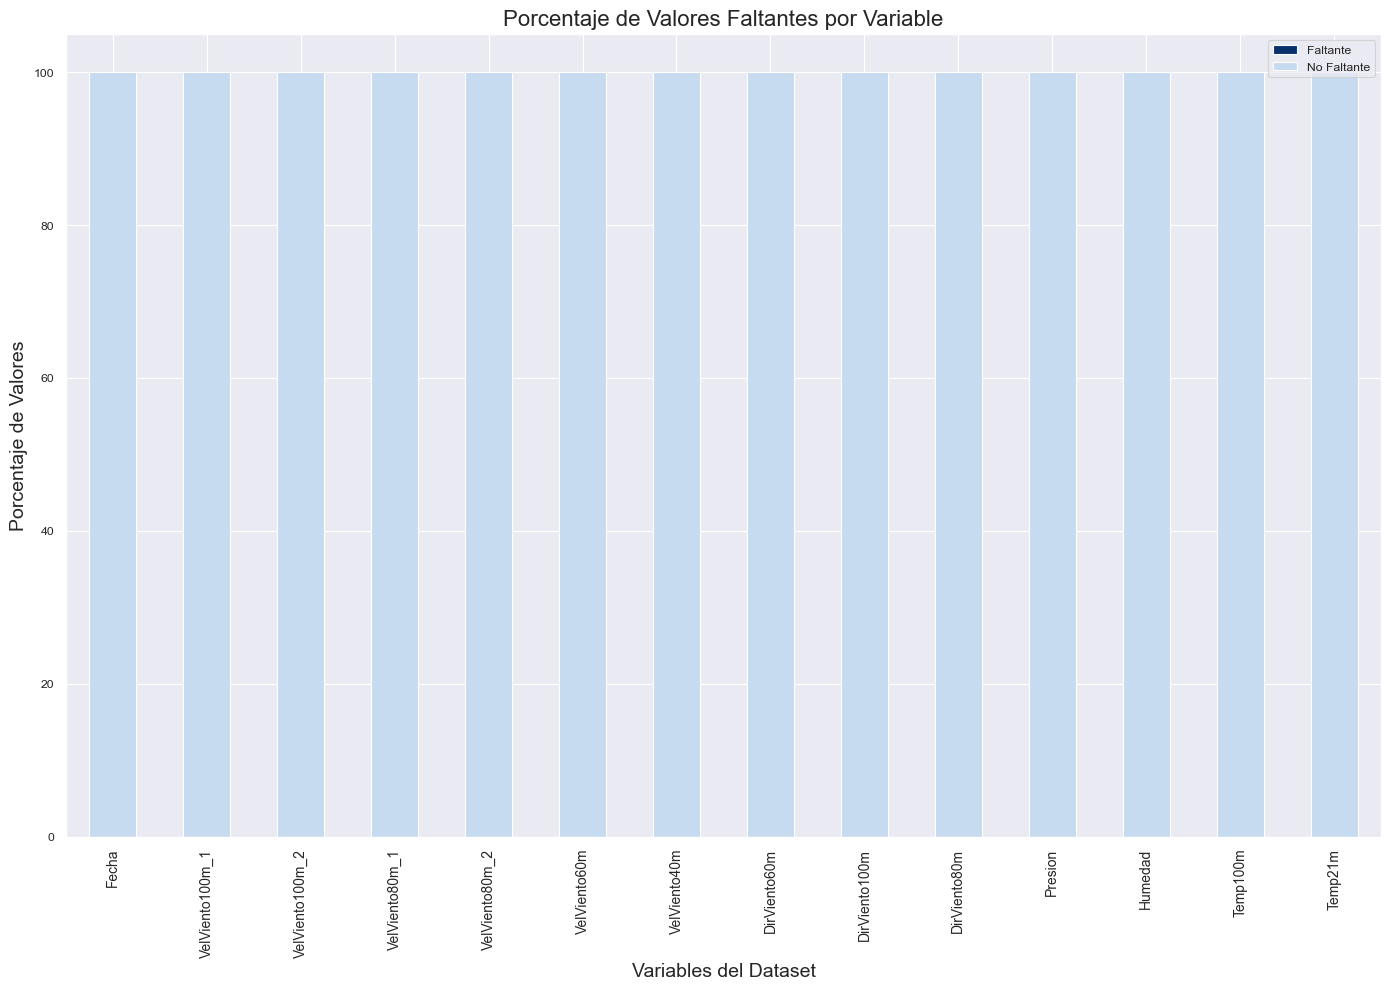

In [250]:
# Calcula el porcentaje de valores faltantes
missing_percentages = (data.isnull().mean() * 100).sort_values(ascending=False)

# Crea un DataFrame para el gráfico de barras apiladas
missing_data = pd.DataFrame({'Faltante': missing_percentages, 'No Faltante': 100 - missing_percentages})

plt.figure(figsize=(14, 10)) 
missing_data.plot(kind='bar', stacked=True, color=['#08306b','#c6dbef'], ax=plt.gca()) 
plt.title('Porcentaje de Valores Faltantes por Variable', fontsize=16)
plt.xlabel('Variables del Dataset', fontsize=14)
plt.ylabel('Porcentaje de Valores', fontsize=14)
plt.xticks(rotation=90, fontsize=10)  
plt.legend(['Faltante', 'No Faltante'], loc='upper right')

plt.tight_layout()

### **Imputación de datos faltantes usando el modelo ARIMA**

In [251]:
missing_percentage = (data.isnull().sum() / len(data)) * 100
missing_percentage.sort_values(ascending = False)

Fecha              0.0
VelViento100m_1    0.0
VelViento100m_2    0.0
VelViento80m_1     0.0
VelViento80m_2     0.0
VelViento60m       0.0
VelViento40m       0.0
DirViento60m       0.0
DirViento100m      0.0
DirViento80m       0.0
Presion            0.0
Humedad            0.0
Temp100m           0.0
Temp21m            0.0
dtype: float64

In [252]:
serie_interes.head()

Fecha
2022-01-01 00:00:00    16.060860
2022-01-01 00:10:00    16.156927
2022-01-01 00:20:00    16.473571
2022-01-01 00:30:00    16.660009
2022-01-01 00:40:00    16.519613
Name: VelViento100m_1, dtype: float64

## **Análisis por variable**

In [253]:
def plot_acf_pacf(data, column, lags = 40, title = ''):
    fig, axes = plt.subplots(1, 2, figsize = (14, 5))
    
    # Gráfico de Autocorrelación (ACF)
    plot_acf(data[column], ax = axes[0], lags = lags)
    axes[0].set_title(f'Autocorrelación (ACF) - {title}')
    
    # Gráfico de Autocorrelación Parcial (PACF)
    plot_pacf(data[column], ax = axes[1], lags = lags)
    axes[1].set_title(f'Autocorrelación Parcial (PACF) - {title}')
    
    plt.tight_layout()
    plt.show()

In [254]:
def descomponer_serie(data, columna, periodo, modelo = 'additive', titulo = 'Serie de tiempo'):

    # Descomposición de la serie temporal
    descomposicion = seasonal_decompose(data[columna].tolist(), period=periodo, model=modelo)

    # Configuración de gráficos
    fig, axarr = plt.subplots(4, sharex=True)
    fig.set_size_inches(10, 14)
    sns.set_theme()
    sns.set_context("paper")

    # Gráfico de la serie original
    data[columna].plot(ax=axarr[0], color='b', linestyle='-')
    axarr[0].set_title(f'{titulo} - Serie original')

    # Gráfico del componente de tendencia
    pd.Series(data=descomposicion.trend, index=data.index).plot(color='r', linestyle='-', ax=axarr[1])
    axarr[1].set_title('Componente tendencial')

    # Gráfico del componente estacional
    pd.Series(data=descomposicion.seasonal, index=data.index).plot(color='g', linestyle='-', ax=axarr[2])
    axarr[2].set_title('Componente estacional')

    # Gráfico del componente de ruido (residual)
    pd.Series(data=descomposicion.resid, index=data.index).plot(color='k', linestyle='-', ax=axarr[3])
    axarr[3].set_title('Variaciones irregulares (Ruido)')

    plt.tight_layout()
    plt.show()

In [255]:
def plot_histogram_and_boxplot(data, column, title):

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Histograma con KDE
    sns.histplot(data[column], kde=True, color='#473C8B', ax=axes[0])
    axes[0].set_title(f'Distribución de {title}')
    axes[0].set_xlabel(column)
    axes[0].set_ylabel('Frecuencia')

    # Diagrama de cajas horizontal
    sns.boxplot(x=data[column], color='#473C8B', ax=axes[1], orient='h')
    axes[1].set_title(f'Diagrama de Cajas de {title}')
    axes[1].set_xlabel(column)
    axes[1].set_ylabel('')


    plt.tight_layout()
    plt.show()



### **Variable: Velocidad del viento a 100m**

#### **Serie original**

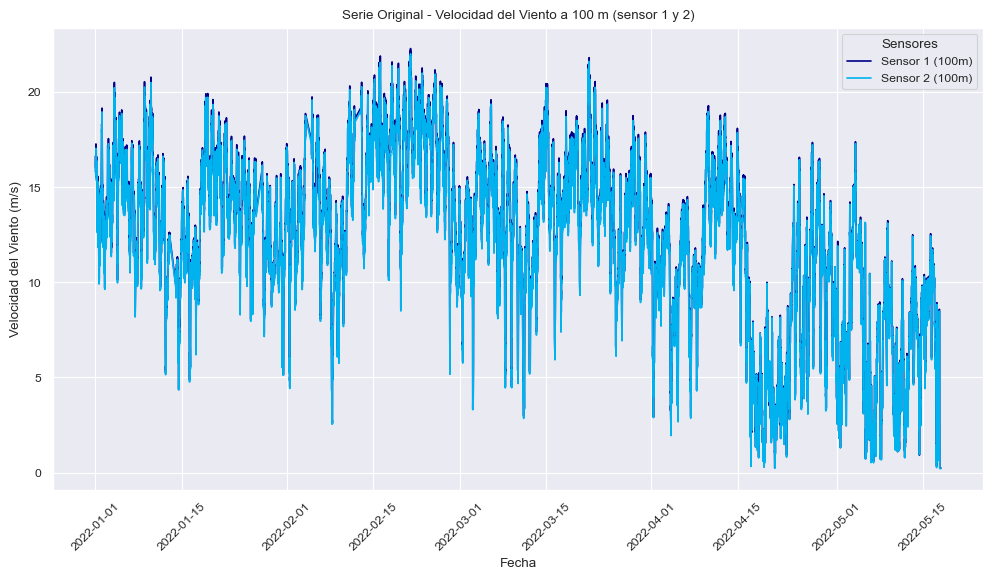

In [256]:
sns.set_theme()
sns.set_context("paper")

plt.figure(figsize = (12, 6))
sns.lineplot(data = data, x =  data['Fecha'], y = data['VelViento100m_1'], label = 'Sensor 1 (100m)', color = '#00008B')
sns.lineplot(data = data, x = data['Fecha'], y = data['VelViento100m_2'], label = 'Sensor 2 (100m)', color = '#00B2EE')

plt.title('Serie Original - Velocidad del Viento a 100 m (sensor 1 y 2)')
plt.xlabel('Fecha')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend(title = 'Sensores', loc = 'upper right')
plt.xticks(rotation=45)

plt.show()


#### **Autocorrelación y autocorrelación parcial**

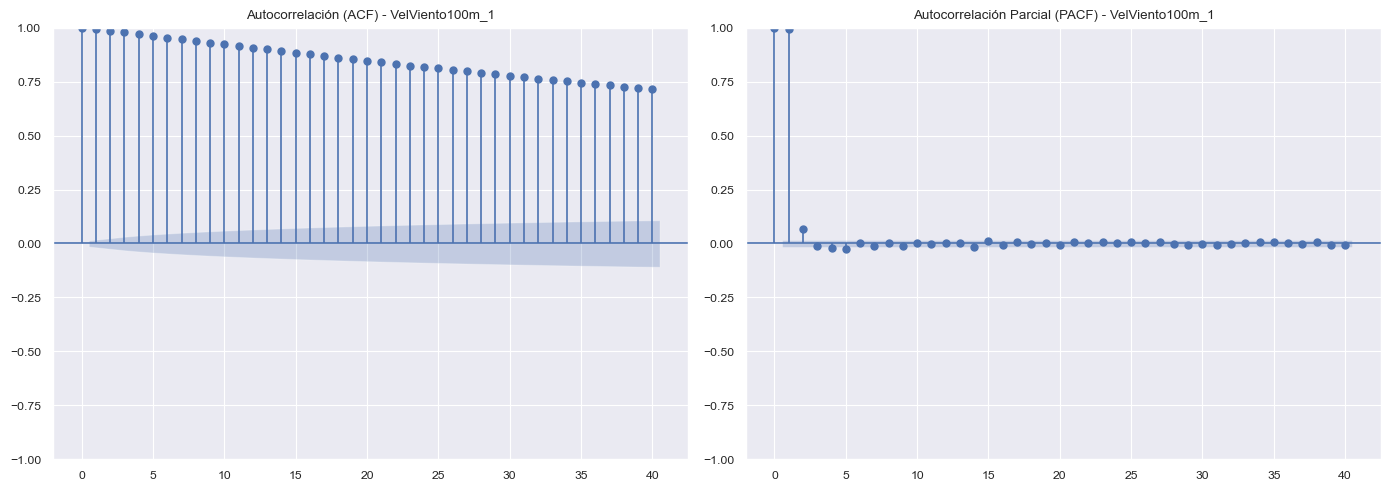

In [257]:
plot_acf_pacf(data, column = 'VelViento100m_1', title = 'VelViento100m_1')

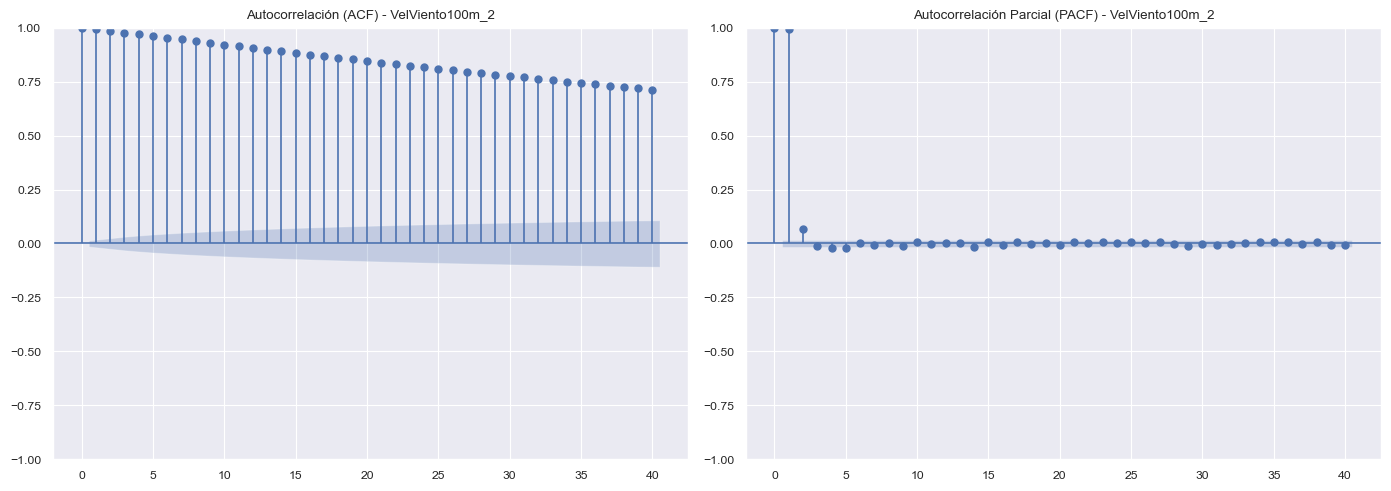

In [258]:
plot_acf_pacf(data, column = 'VelViento100m_2', title = 'VelViento100m_2')

#### **Descomposición de la serie**

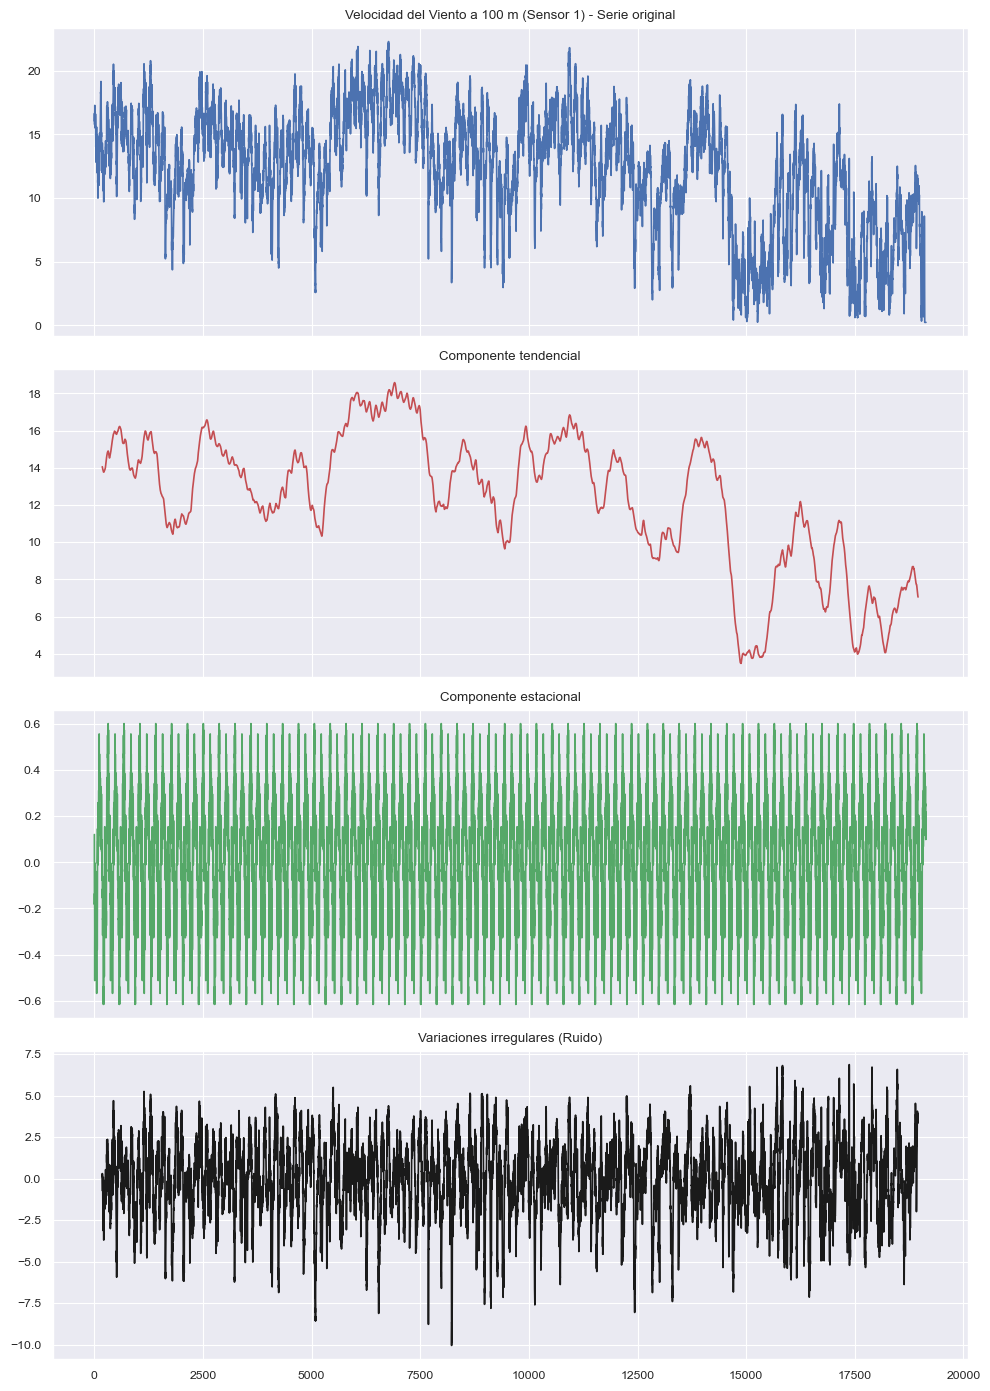

In [259]:
descomponer_serie(data, columna = 'VelViento100m_1', periodo = 365, modelo = 'additive', titulo = 'Velocidad del Viento a 100 m (Sensor 1)')

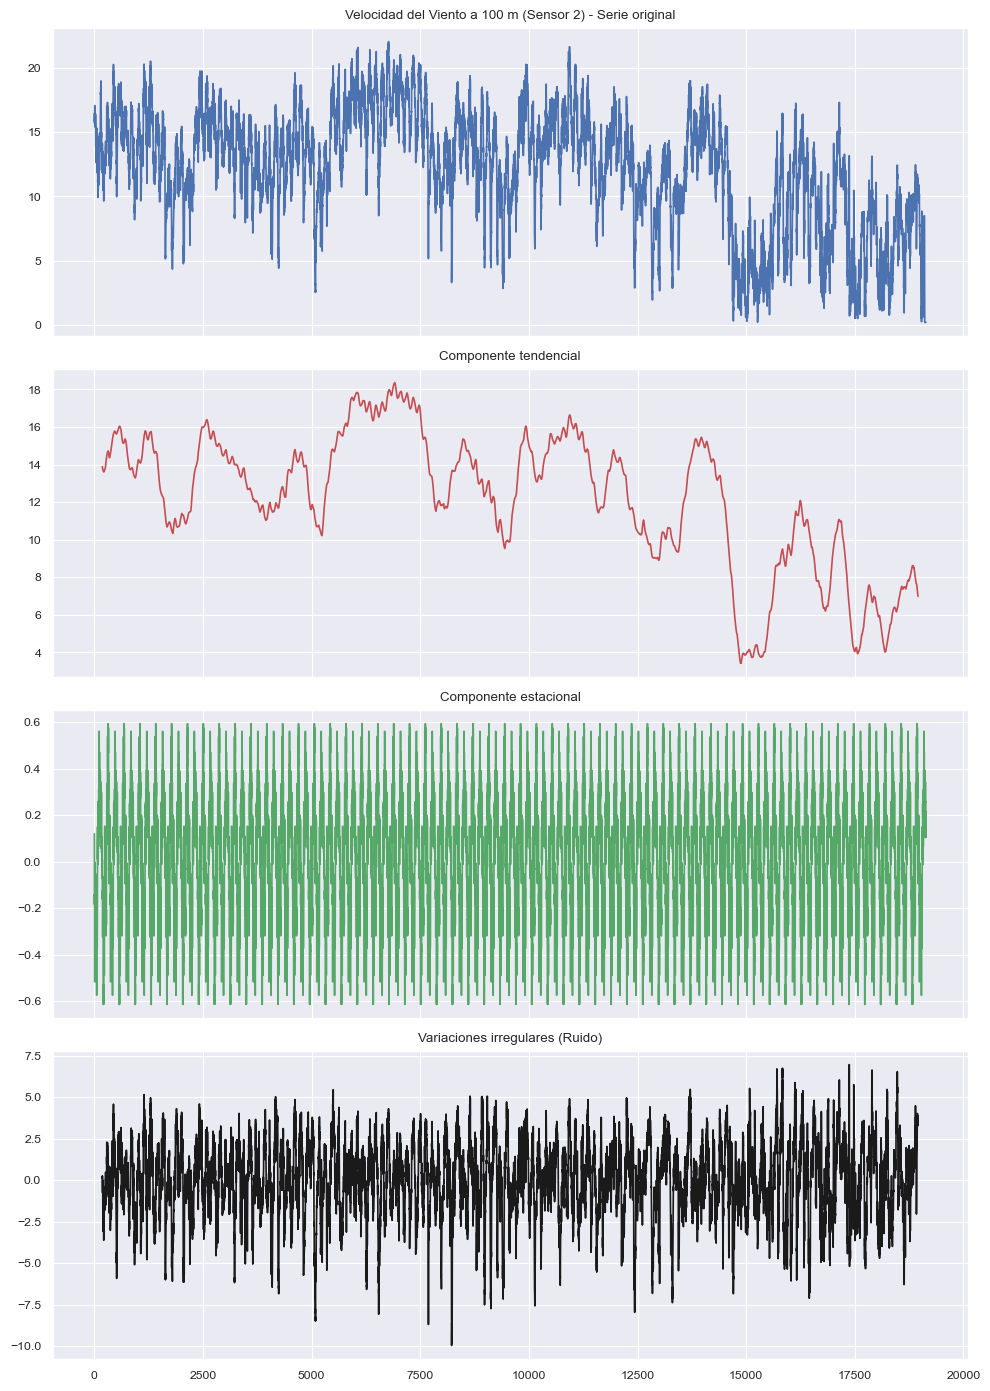

In [260]:
descomponer_serie(data, columna = 'VelViento100m_2', periodo = 365, modelo = 'additive', titulo = 'Velocidad del Viento a 100 m (Sensor 2)')

#### **Distribución de la variable**

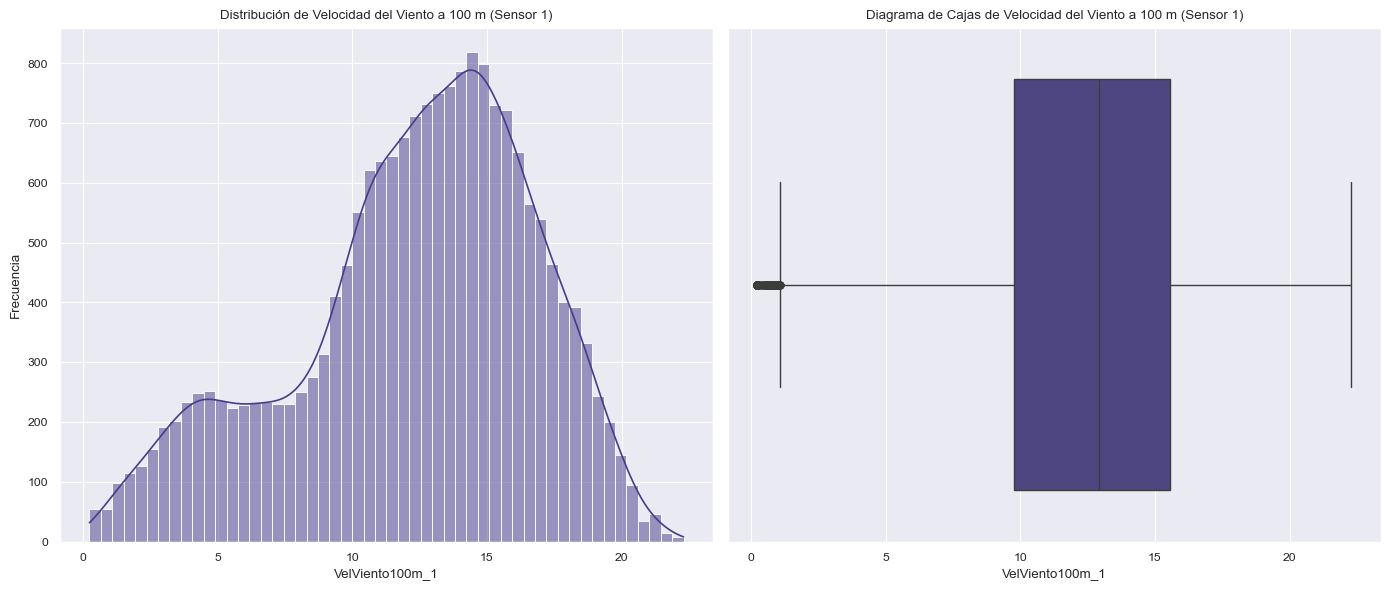

In [261]:
plot_histogram_and_boxplot(data, 'VelViento100m_1', 'Velocidad del Viento a 100 m (Sensor 1)')

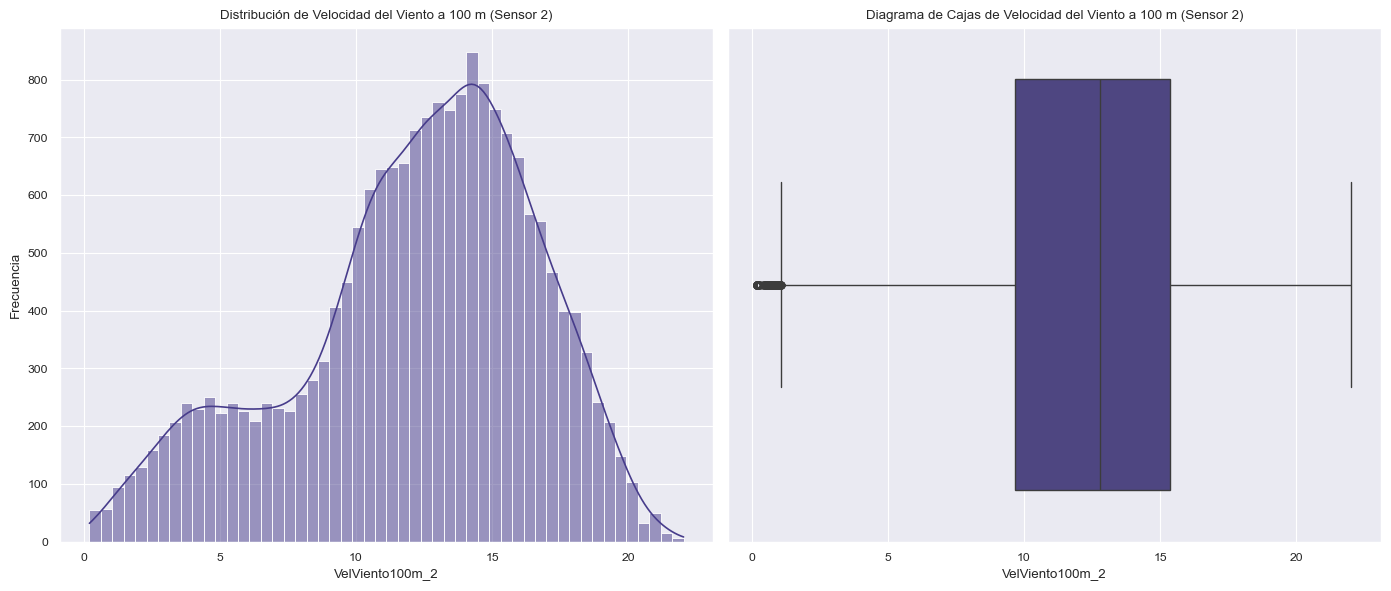

In [262]:
plot_histogram_and_boxplot(data, 'VelViento100m_2', 'Velocidad del Viento a 100 m (Sensor 2)')

### **Variable: Velocidad del viento a 80m**

#### **Serie original**

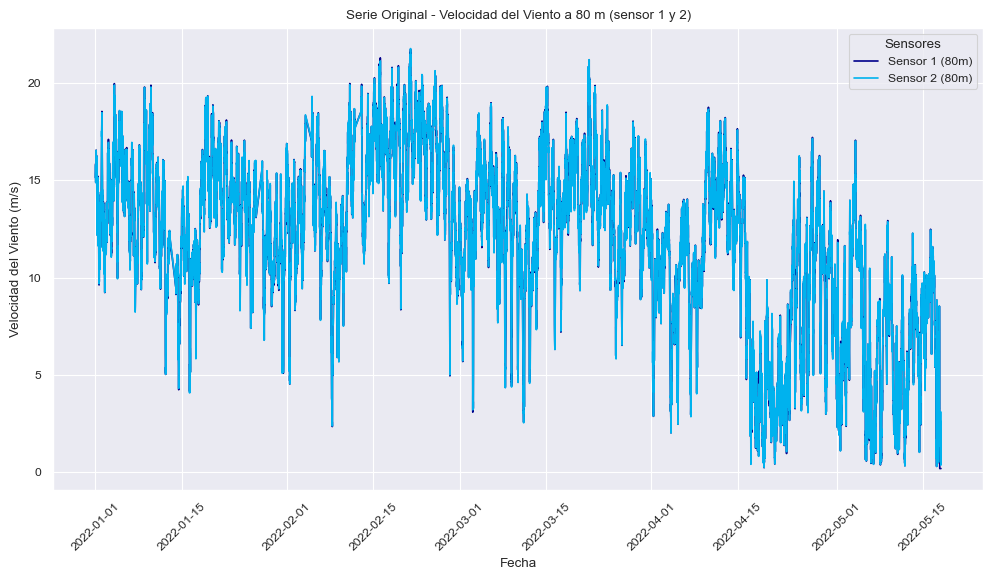

In [263]:
sns.set_theme()
sns.set_context("paper")

plt.figure(figsize = (12, 6))
sns.lineplot(data = data, x =  data['Fecha'], y = data['VelViento80m_1'], label = 'Sensor 1 (80m)', color = '#00008B')
sns.lineplot(data = data, x = data['Fecha'], y = data['VelViento80m_2'], label = 'Sensor 2 (80m)', color = '#00B2EE')

plt.title('Serie Original - Velocidad del Viento a 80 m (sensor 1 y 2)')
plt.xlabel('Fecha')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend(title = 'Sensores', loc = 'upper right')
plt.xticks(rotation=45)

plt.show()

#### **Autocorrelación y autocorrelación parcial**

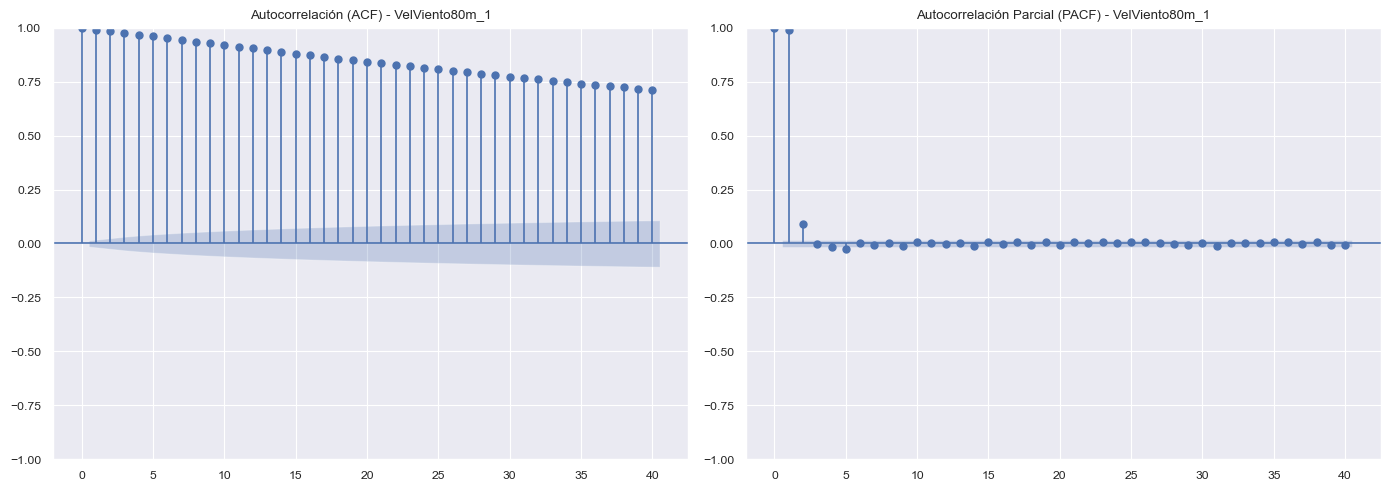

In [264]:
plot_acf_pacf(data, column = 'VelViento80m_1', title = 'VelViento80m_1')

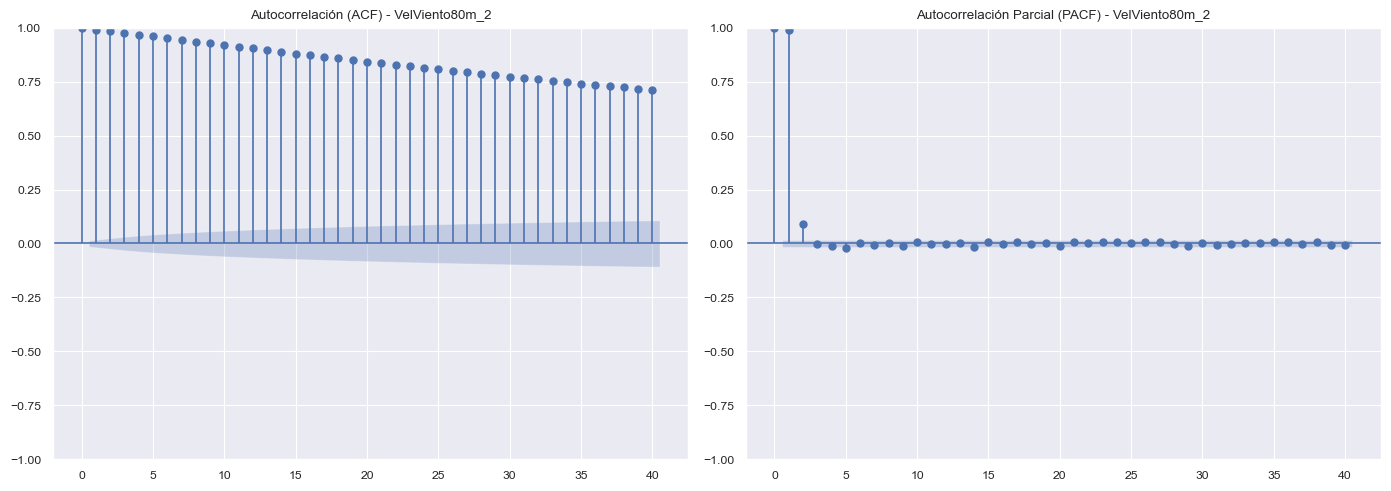

In [265]:
plot_acf_pacf(data, column = 'VelViento80m_2', title = 'VelViento80m_2')

#### **Descomposición de la serie**

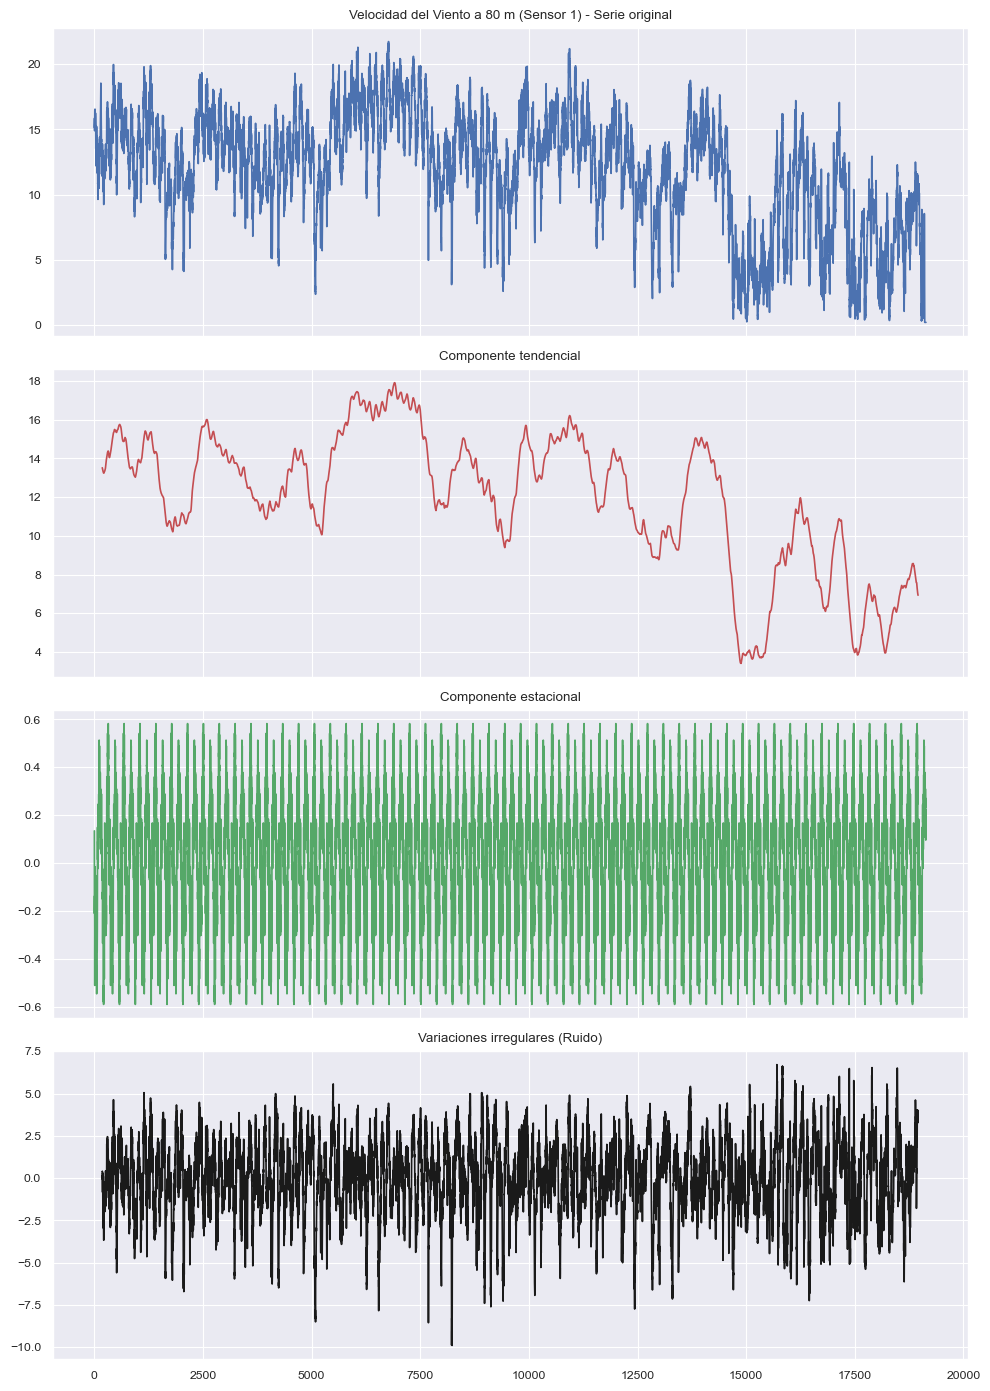

In [266]:
descomponer_serie(data, columna = 'VelViento80m_1', periodo = 365, modelo = 'additive', titulo = 'Velocidad del Viento a 80 m (Sensor 1)')

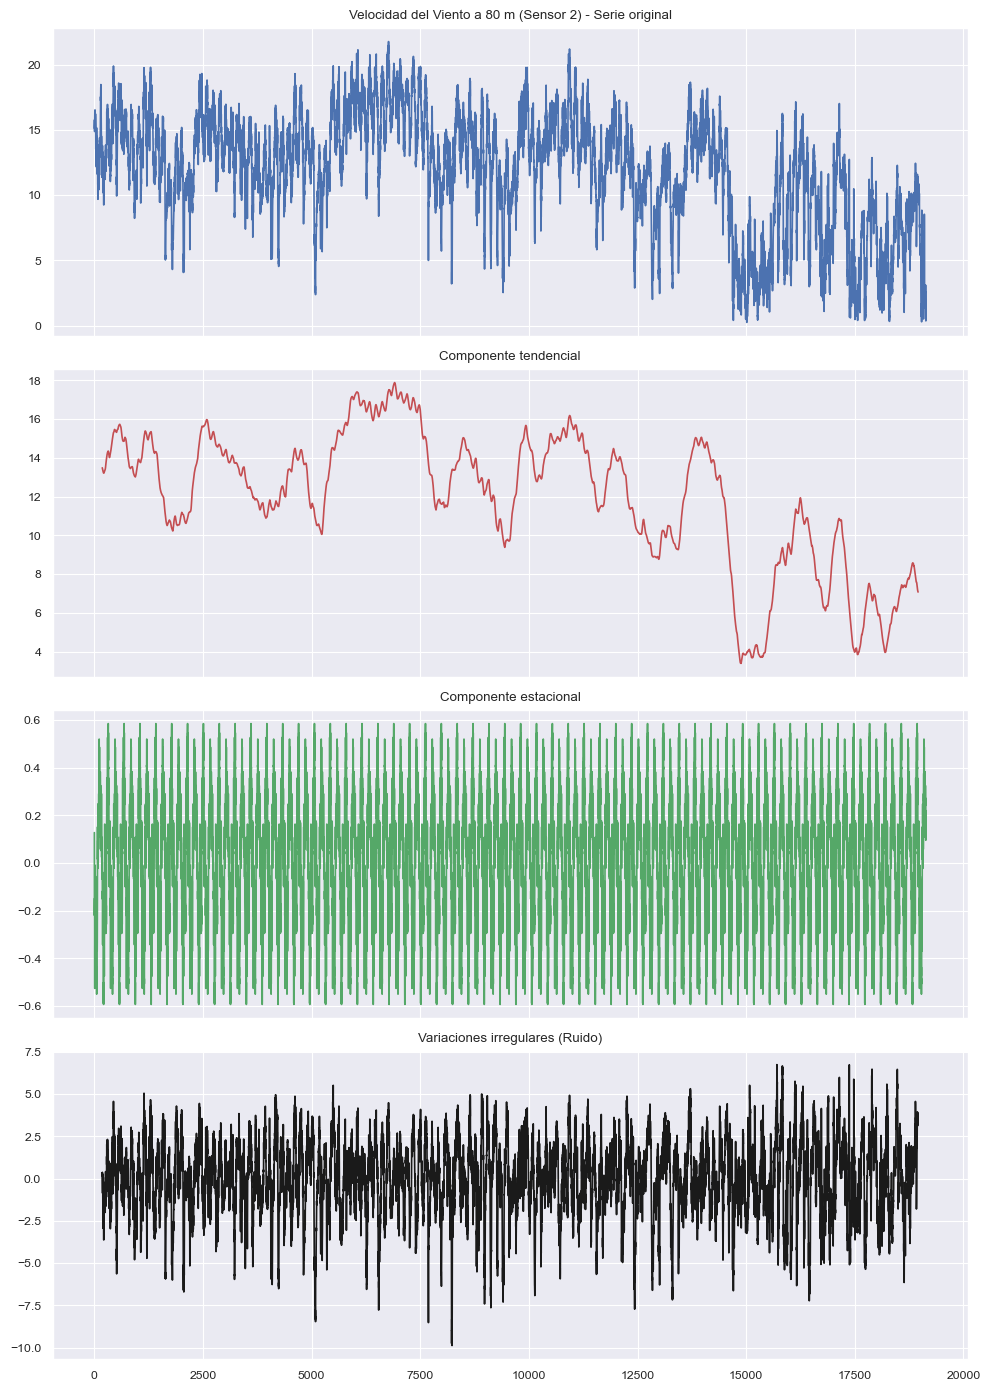

In [267]:
descomponer_serie(data, columna = 'VelViento80m_2', periodo = 365, modelo = 'additive', titulo = 'Velocidad del Viento a 80 m (Sensor 2)')

#### **Distribución de la variable**

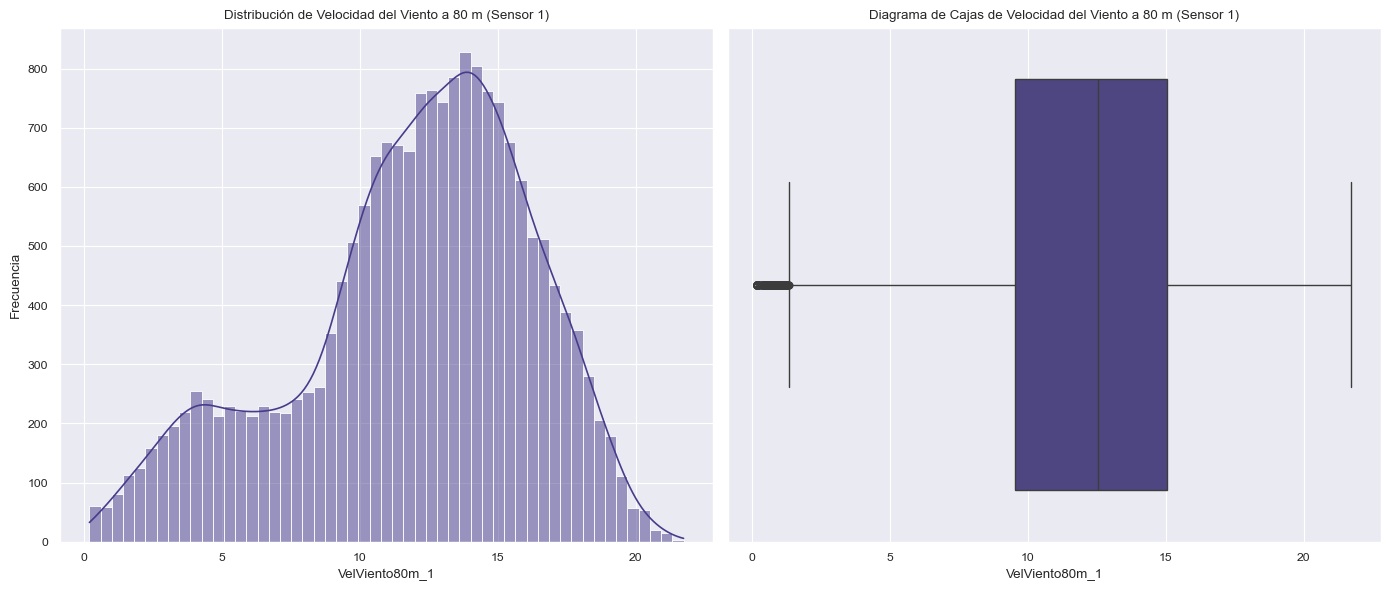

In [268]:
plot_histogram_and_boxplot(data, 'VelViento80m_1', 'Velocidad del Viento a 80 m (Sensor 1)')

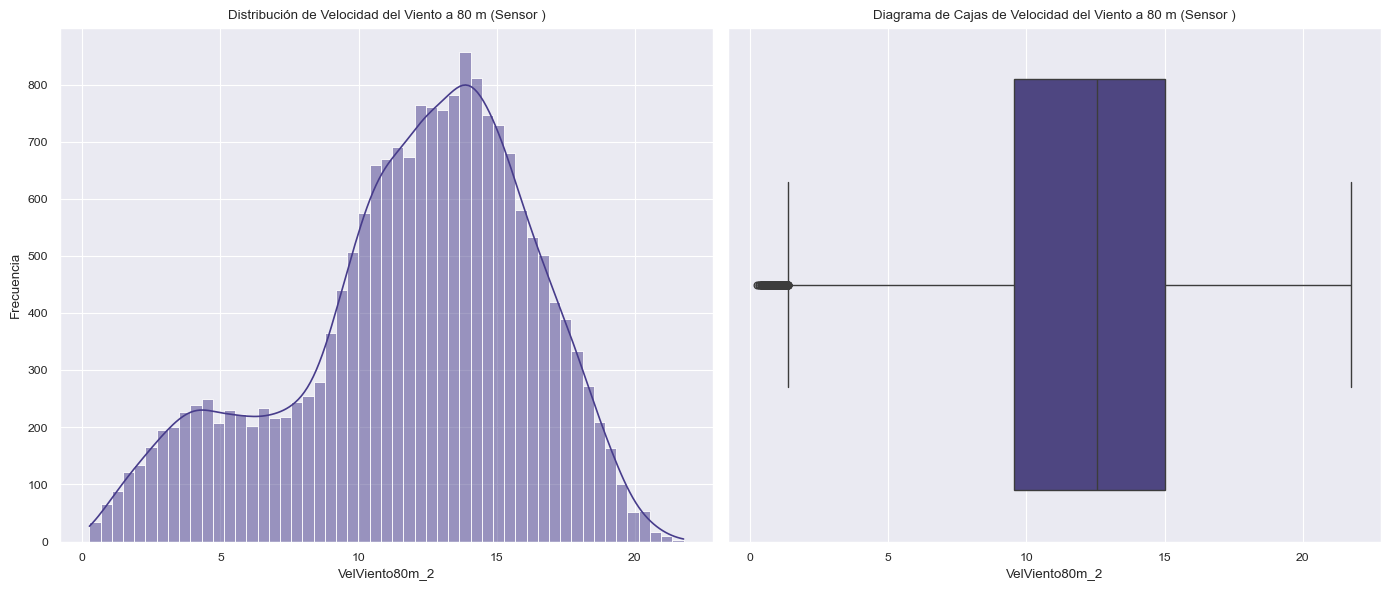

In [269]:
plot_histogram_and_boxplot(data, 'VelViento80m_2', 'Velocidad del Viento a 80 m (Sensor )')

### **Variable: Velocidad del viento a 60m**

#### **Serie original**

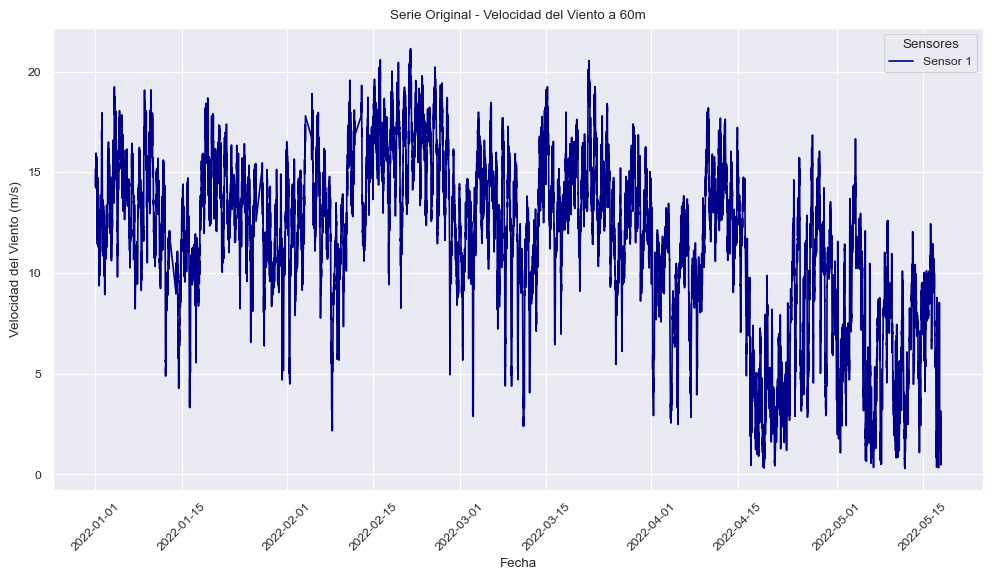

In [270]:
sns.set_theme()
sns.set_context("paper")

plt.figure(figsize = (12, 6))
sns.lineplot(data = data, x =  data['Fecha'], y = data['VelViento60m'], label = 'Sensor 1', color = '#00008B')

plt.title('Serie Original - Velocidad del Viento a 60m')
plt.xlabel('Fecha')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend(title = 'Sensores', loc = 'upper right')
plt.xticks(rotation=45)

plt.show()

#### **Autocorrelación y autocorrelación parcial**

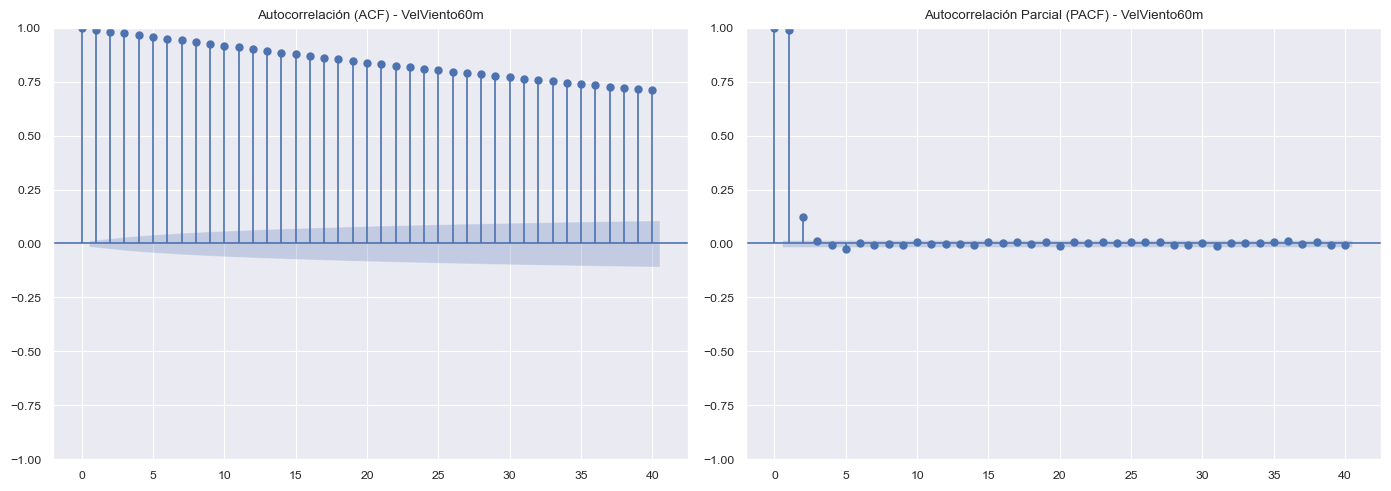

In [271]:
plot_acf_pacf(data, column = 'VelViento60m', title = 'VelViento60m')

#### **Descomposición de la serie**

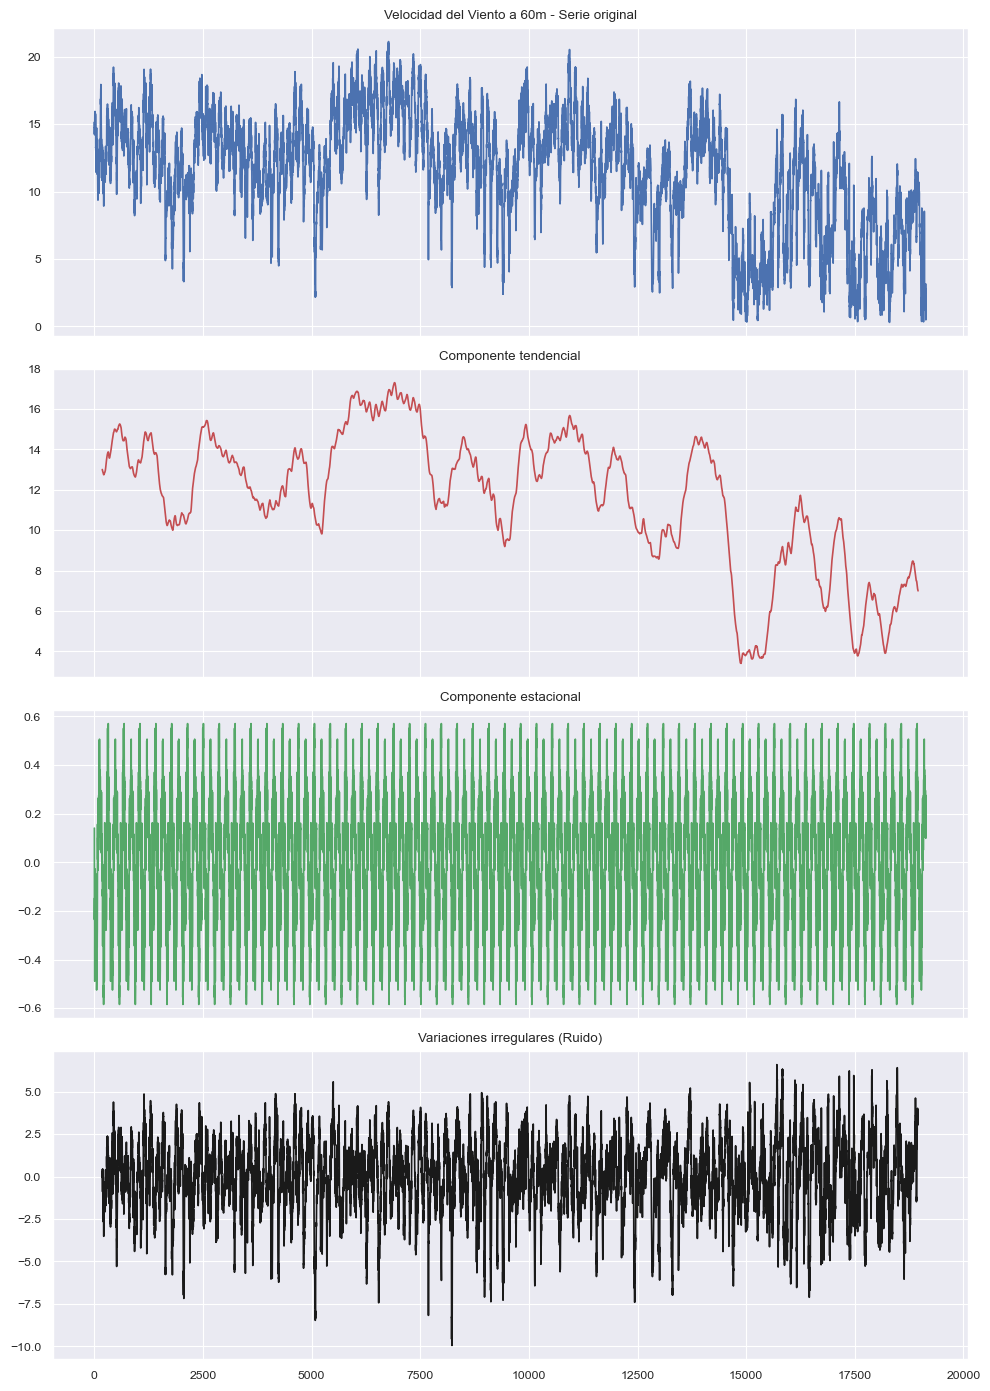

In [272]:
descomponer_serie(data, columna = 'VelViento60m', periodo = 365, modelo = 'additive', titulo = 'Velocidad del Viento a 60m')

#### **Distribución de la variable**

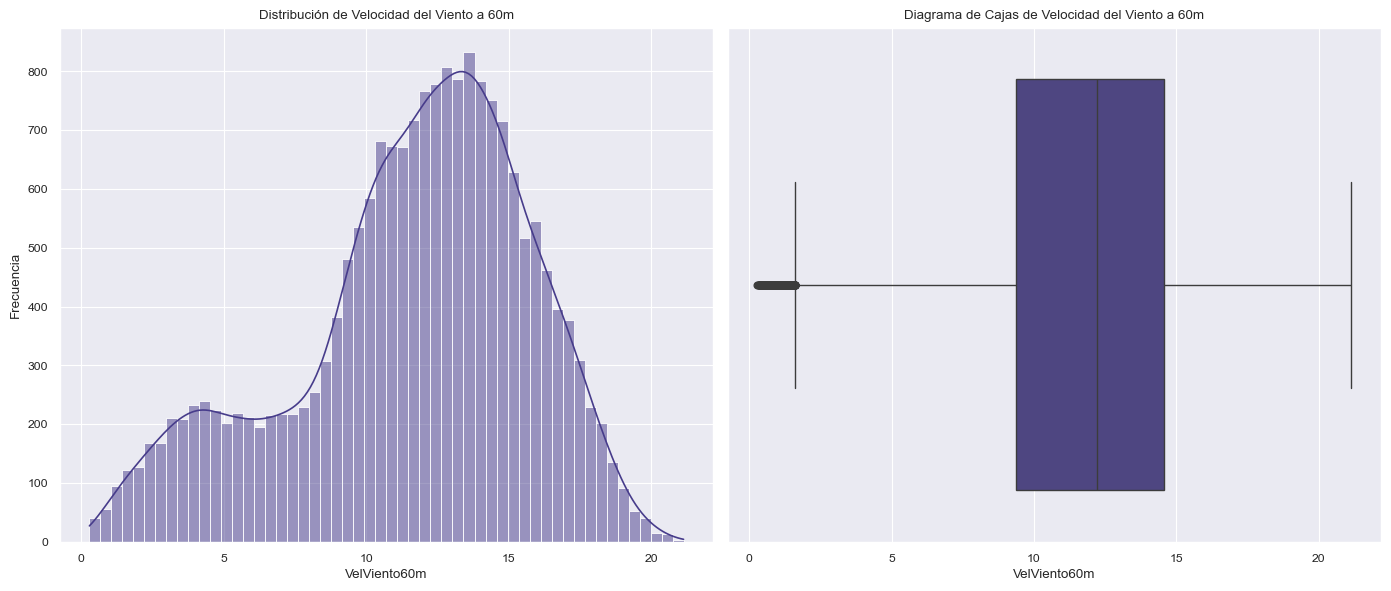

In [273]:
plot_histogram_and_boxplot(data, 'VelViento60m', 'Velocidad del Viento a 60m')

### **Variable: Velocidad del viento a 40m**

#### **Serie original**

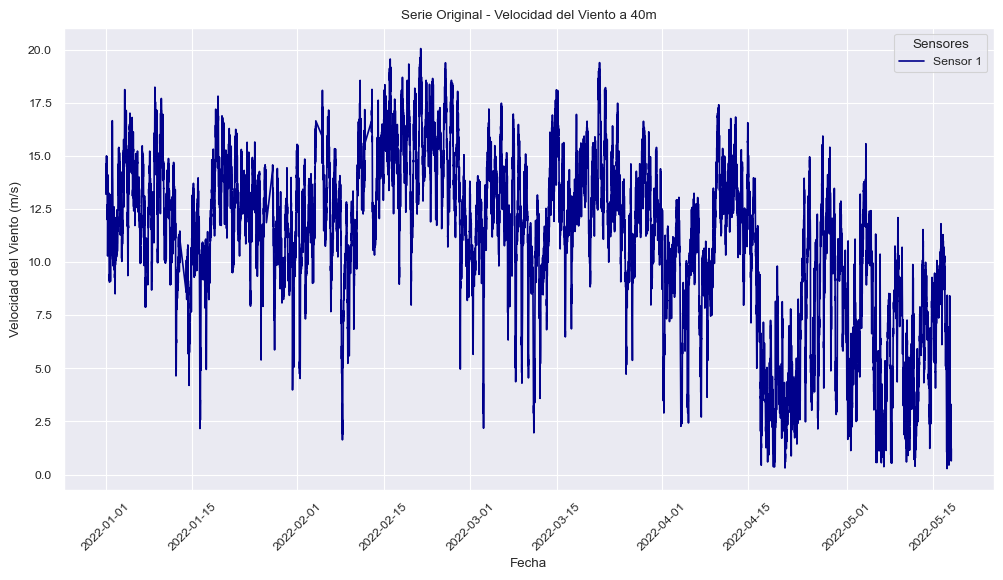

In [274]:
sns.set_theme()
sns.set_context("paper")

plt.figure(figsize = (12, 6))
sns.lineplot(data = data, x =  data['Fecha'], y = data['VelViento40m'], label = 'Sensor 1', color = '#00008B')

plt.title('Serie Original - Velocidad del Viento a 40m')
plt.xlabel('Fecha')
plt.ylabel('Velocidad del Viento (m/s)')
plt.legend(title = 'Sensores', loc = 'upper right')
plt.xticks(rotation=45)

plt.show()

#### **Autocorrelación y autocorrelación parcial**

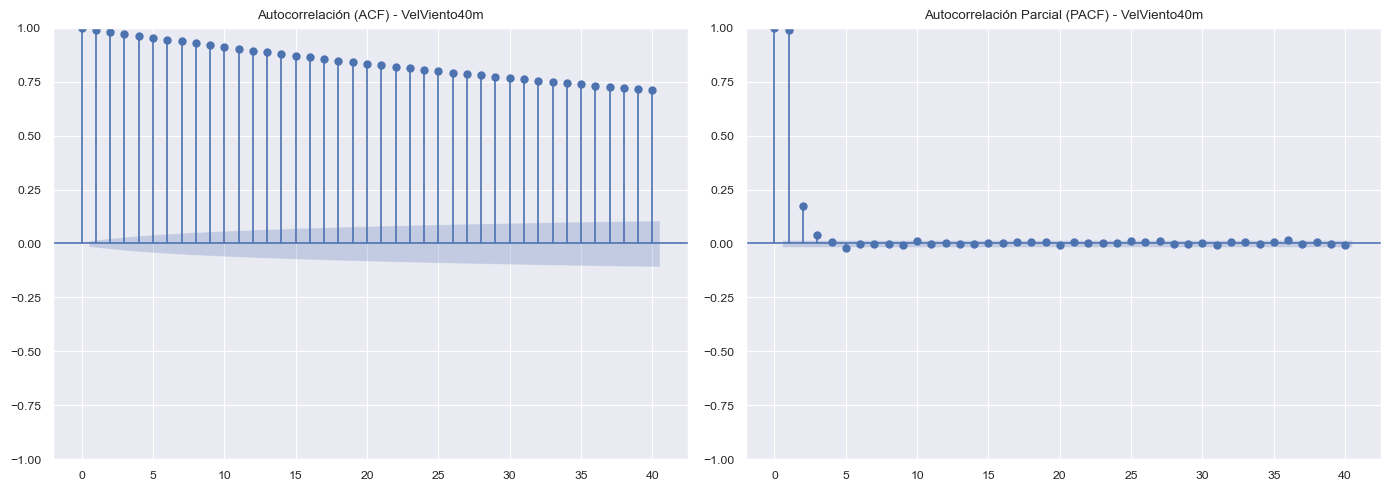

In [275]:
plot_acf_pacf(data, column = 'VelViento40m', title = 'VelViento40m')

#### **Descomposición de la serie**

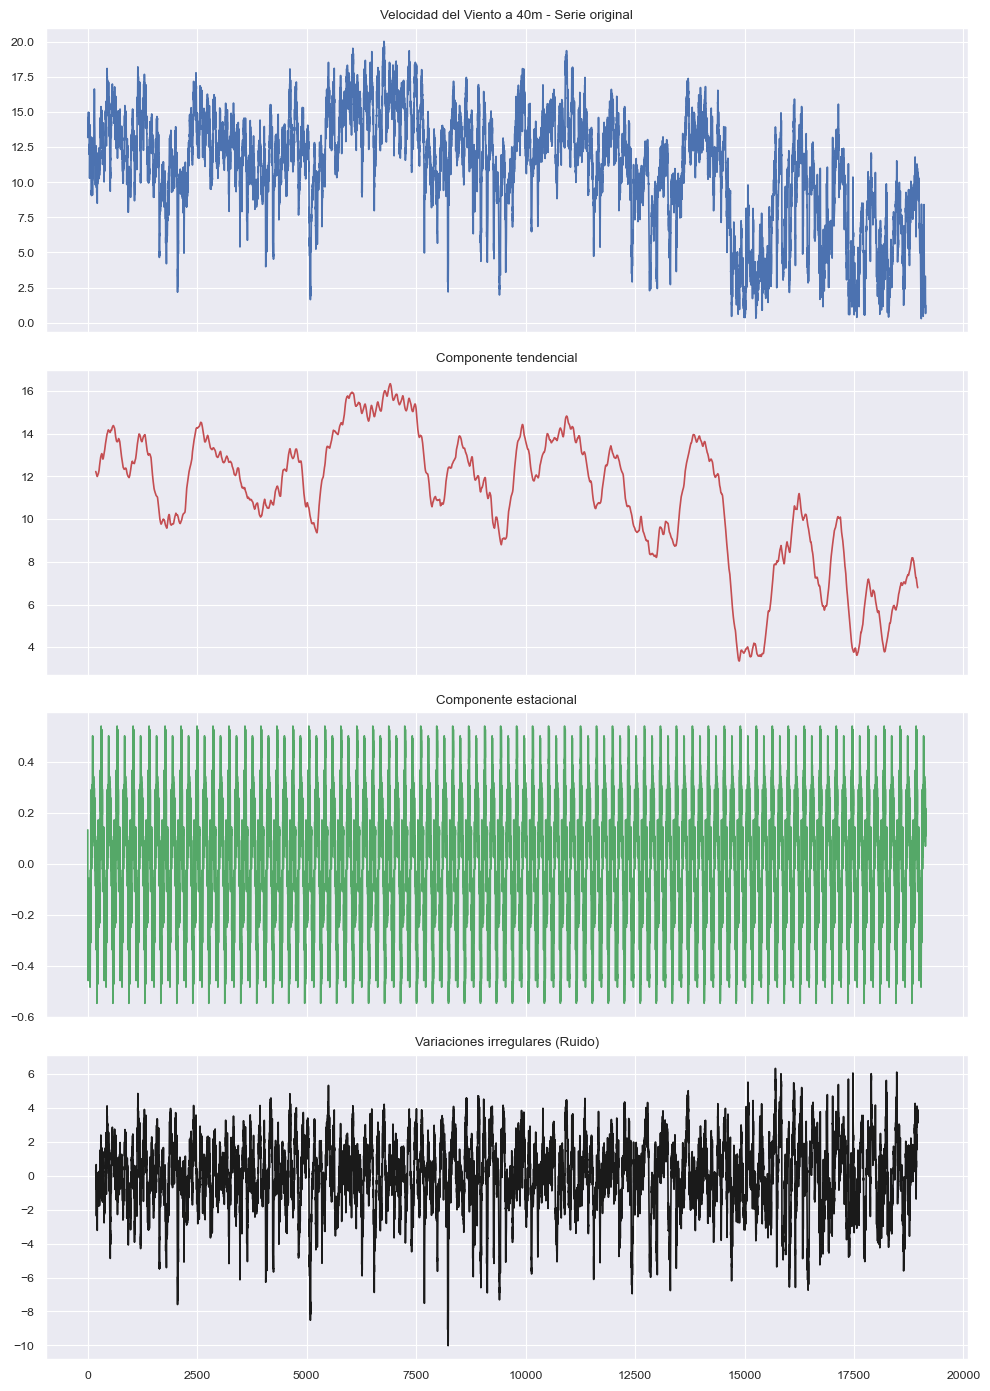

In [276]:
descomponer_serie(data, columna = 'VelViento40m', periodo = 365, modelo = 'additive', titulo = 'Velocidad del Viento a 40m')

#### **Distribución de la variable**

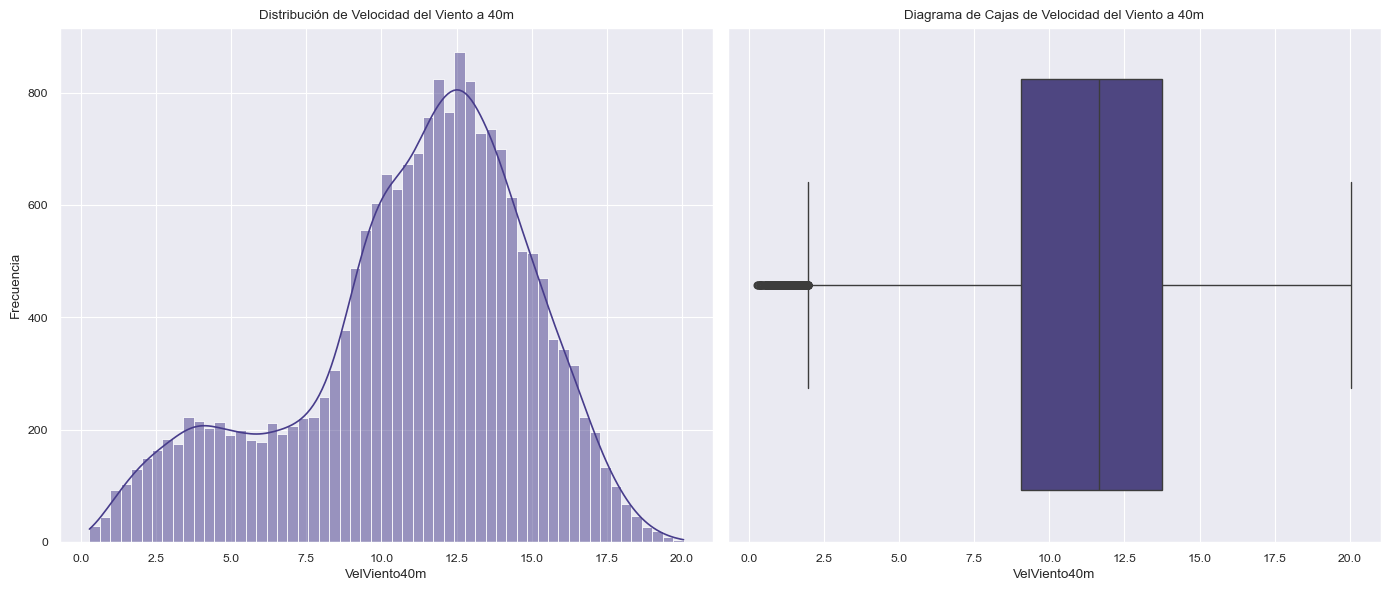

In [277]:
plot_histogram_and_boxplot(data, 'VelViento40m', 'Velocidad del Viento a 40m')

### **Variables: Dirección del viento a 100m, 80m y 60m**

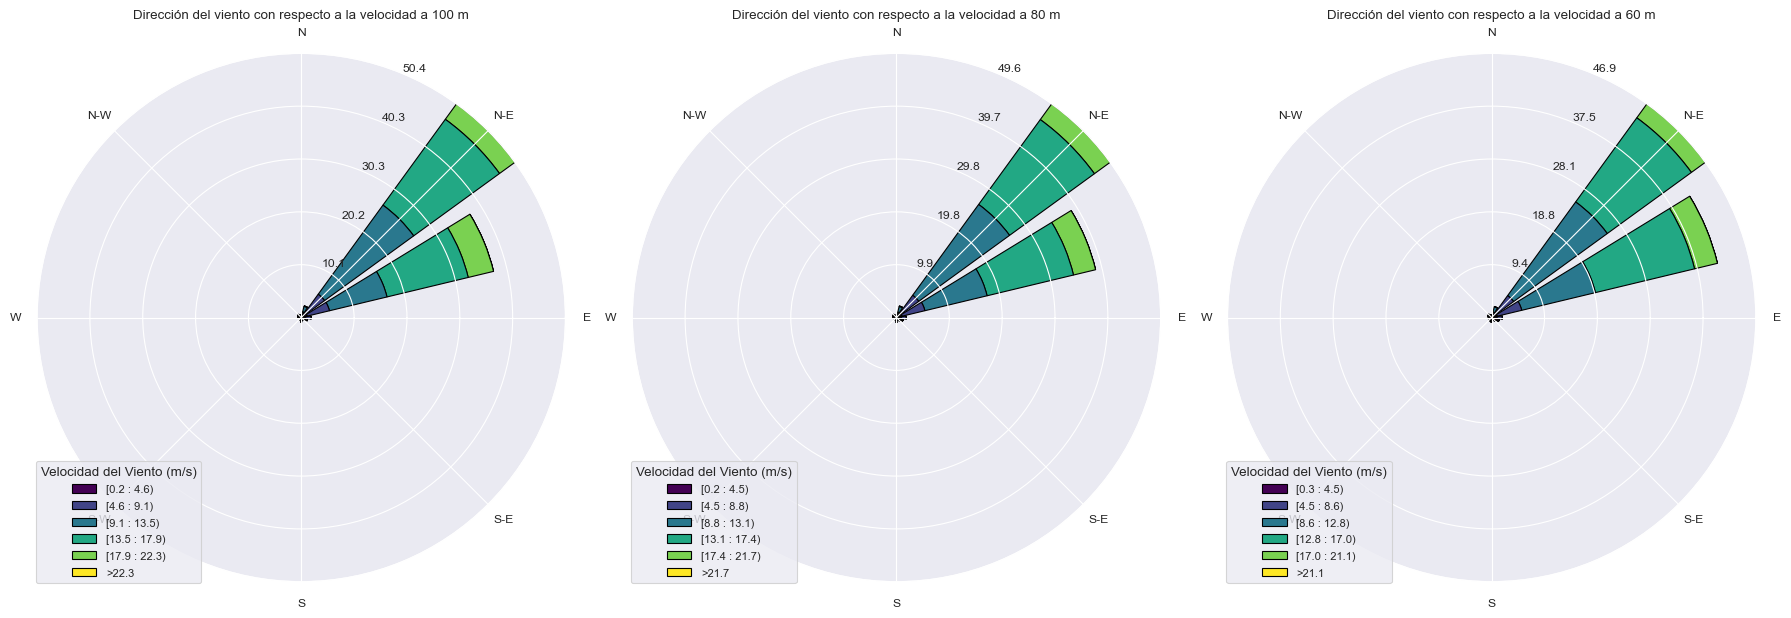

In [278]:
# Configura el tamaño de la figura y establece los subgráficos
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(projection='windrose'))
color_palette = cm.viridis 

# Gráfico de dirección del viento a 100 m
ax = axes[0]
ax.bar(data['DirViento100m'], data['VelViento100m_1'], normed=True, opening=0.8, edgecolor='black', cmap=color_palette)
ax.set_title('Dirección del viento con respecto a la velocidad a 100 m')
ax.set_legend(title='Velocidad del Viento (m/s)', loc='lower left')

# Gráfico de dirección del viento a 80 m
ax = axes[1]
ax.bar(data['DirViento80m'], data['VelViento80m_1'], normed=True, opening=0.8, edgecolor='black', cmap=color_palette)
ax.set_title('Dirección del viento con respecto a la velocidad a 80 m')
ax.set_legend(title='Velocidad del Viento (m/s)', loc='lower left')

# Gráfico de dirección del viento a 60 m
ax = axes[2]
ax.bar(data['DirViento60m'], data['VelViento60m'], normed=True, opening=0.8, edgecolor='black', cmap=color_palette)
ax.set_title('Dirección del viento con respecto a la velocidad a 60 m')
ax.set_legend(title='Velocidad del Viento (m/s)', loc='lower left')

plt.tight_layout()
plt.show()


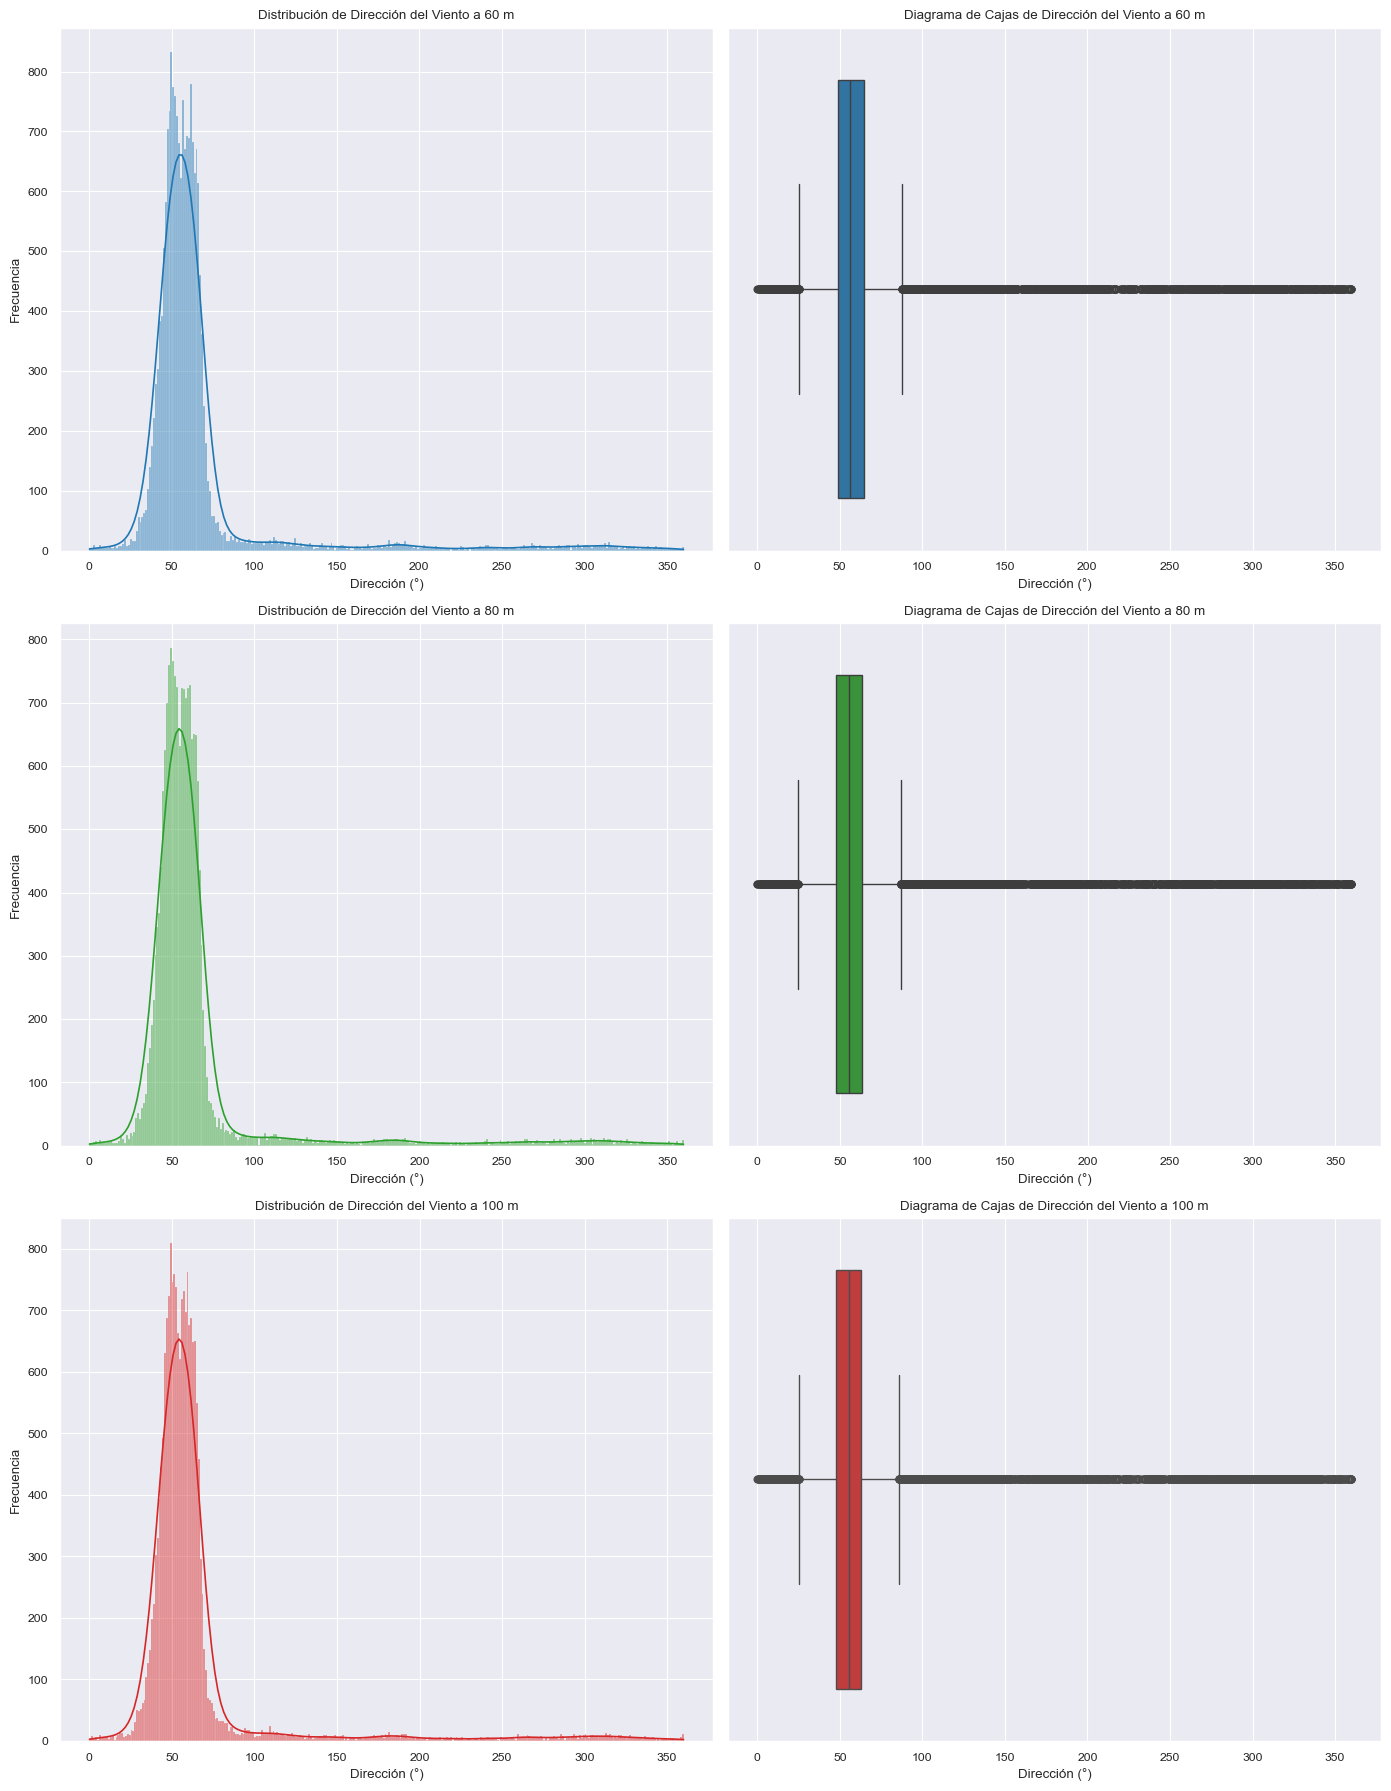

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una figura con tres filas y dos columnas
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# Configuración para DirViento60m
sns.histplot(data['DirViento60m'], kde=True, color='#1f77b4', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Dirección del Viento a 60 m')
axes[0, 0].set_xlabel('Dirección (°)')
axes[0, 0].set_ylabel('Frecuencia')

sns.boxplot(x=data['DirViento60m'], color='#1f77b4', ax=axes[0, 1], orient='h')
axes[0, 1].set_title('Diagrama de Cajas de Dirección del Viento a 60 m')
axes[0, 1].set_xlabel('Dirección (°)')

# Configuración para DirViento80m
sns.histplot(data['DirViento80m'], kde=True, color='#2ca02c', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Dirección del Viento a 80 m')
axes[1, 0].set_xlabel('Dirección (°)')
axes[1, 0].set_ylabel('Frecuencia')

sns.boxplot(x=data['DirViento80m'], color='#2ca02c', ax=axes[1, 1], orient='h')
axes[1, 1].set_title('Diagrama de Cajas de Dirección del Viento a 80 m')
axes[1, 1].set_xlabel('Dirección (°)')

# Configuración para DirViento100m
sns.histplot(data['DirViento100m'], kde=True, color='#d62728', ax=axes[2, 0])
axes[2, 0].set_title('Distribución de Dirección del Viento a 100 m')
axes[2, 0].set_xlabel('Dirección (°)')
axes[2, 0].set_ylabel('Frecuencia')

sns.boxplot(x=data['DirViento100m'], color='#d62728', ax=axes[2, 1], orient='h')
axes[2, 1].set_title('Diagrama de Cajas de Dirección del Viento a 100 m')
axes[2, 1].set_xlabel('Dirección (°)')

# Ajustar el diseño
plt.tight_layout()
plt.show()


### **Variable: Presión**

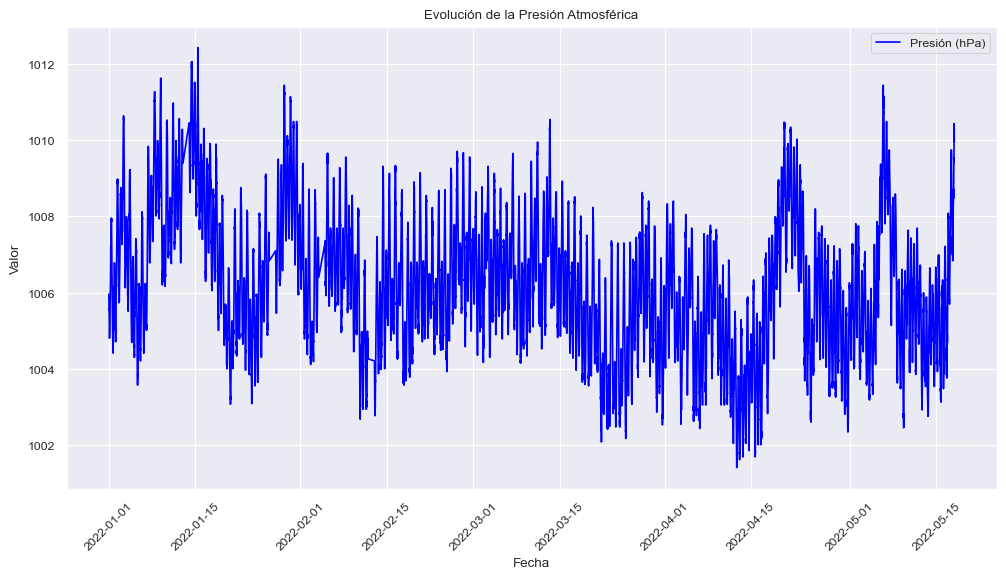

In [280]:
plt.figure(figsize=(12, 6))
plt.plot(data['Fecha'], data['Presion'], color='blue', label='Presión (hPa)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Evolución de la Presión Atmosférica')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


#### **Distribución de la variable**

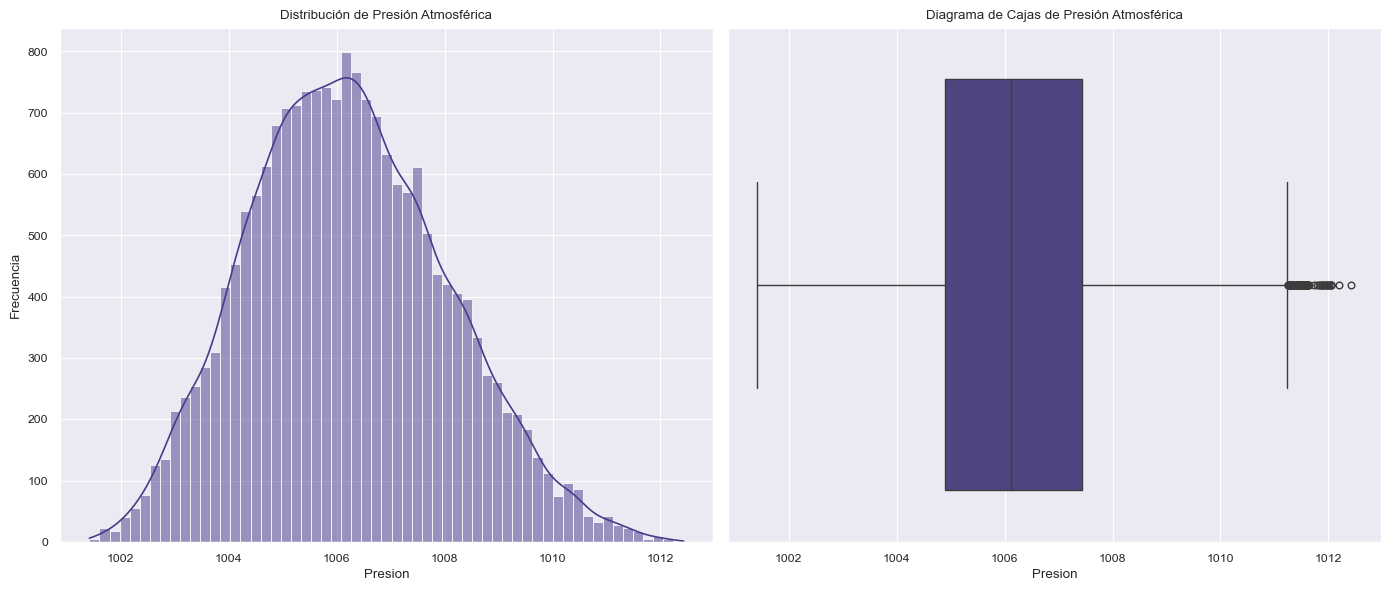

In [281]:
plot_histogram_and_boxplot(data, 'Presion', 'Presión Atmosférica')	

### **Variable: Humedad**

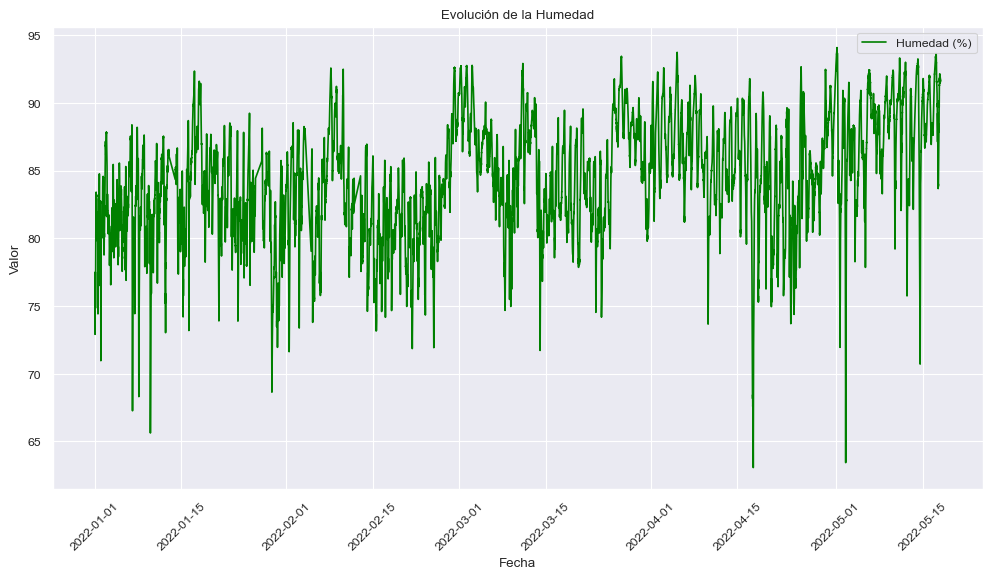

In [282]:
plt.figure(figsize=(12, 6))
plt.plot(data['Fecha'], data['Humedad'], color='green', label='Humedad (%)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Evolución de la Humedad')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### **Distribución de la variable**

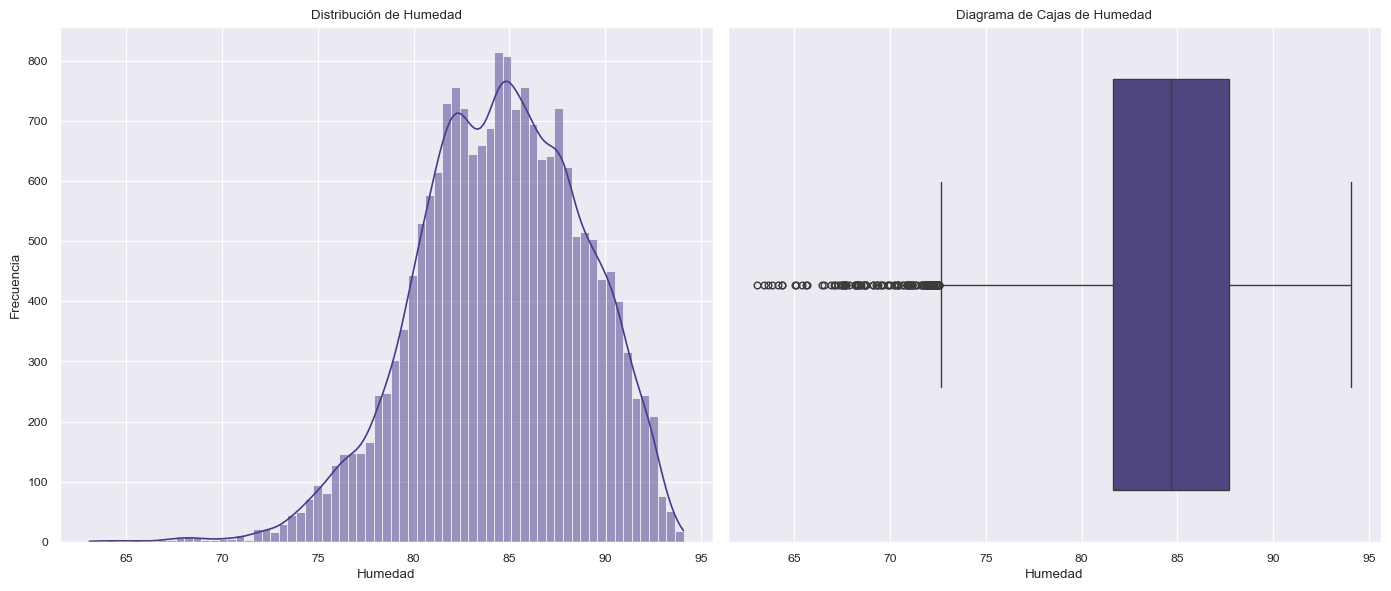

In [283]:
plot_histogram_and_boxplot(data, 'Humedad', 'Humedad')

### **Variables: Temperatura a 100m y 20m**

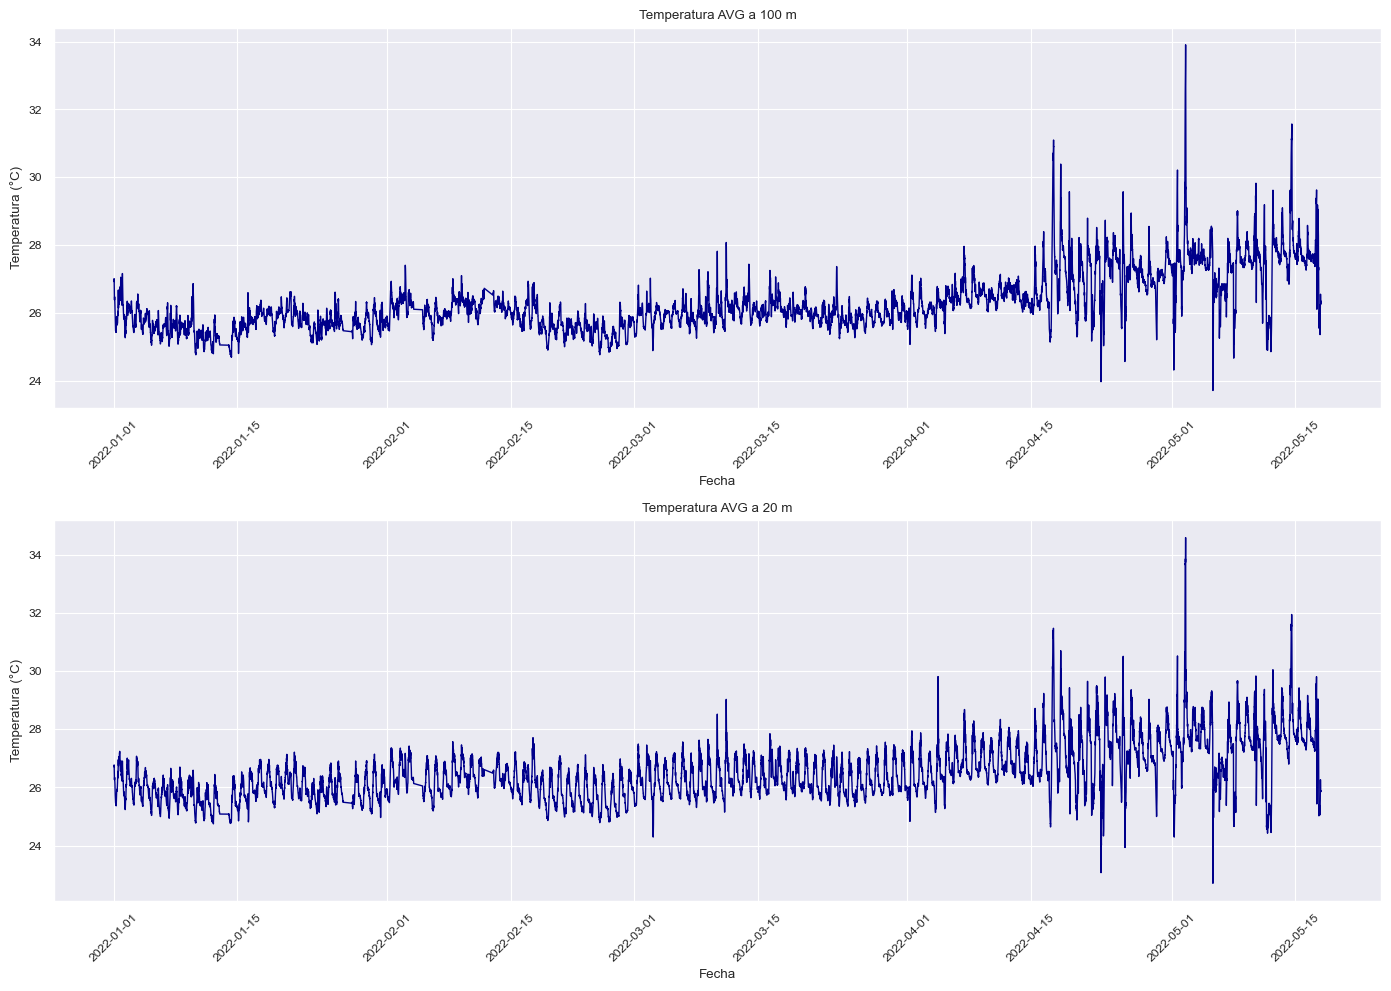

In [284]:
fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# 1. Gráfico de Temperatura AVG a 100 m
axs[0].plot(data['Fecha'], data['Temp100m'], color='#00008B', linewidth=1)
axs[0].set_title('Temperatura AVG a 100 m')
axs[0].set_xlabel('Fecha')
axs[0].set_ylabel('Temperatura (°C)')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# 2. Gráfico de Temperatura AVG a 20 m
axs[1].plot(data['Fecha'], data['Temp21m'], color='#00008B', linewidth=1)
axs[1].set_title('Temperatura AVG a 20 m')
axs[1].set_xlabel('Fecha')
axs[1].set_ylabel('Temperatura (°C)')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

plt.tight_layout()
plt.show()


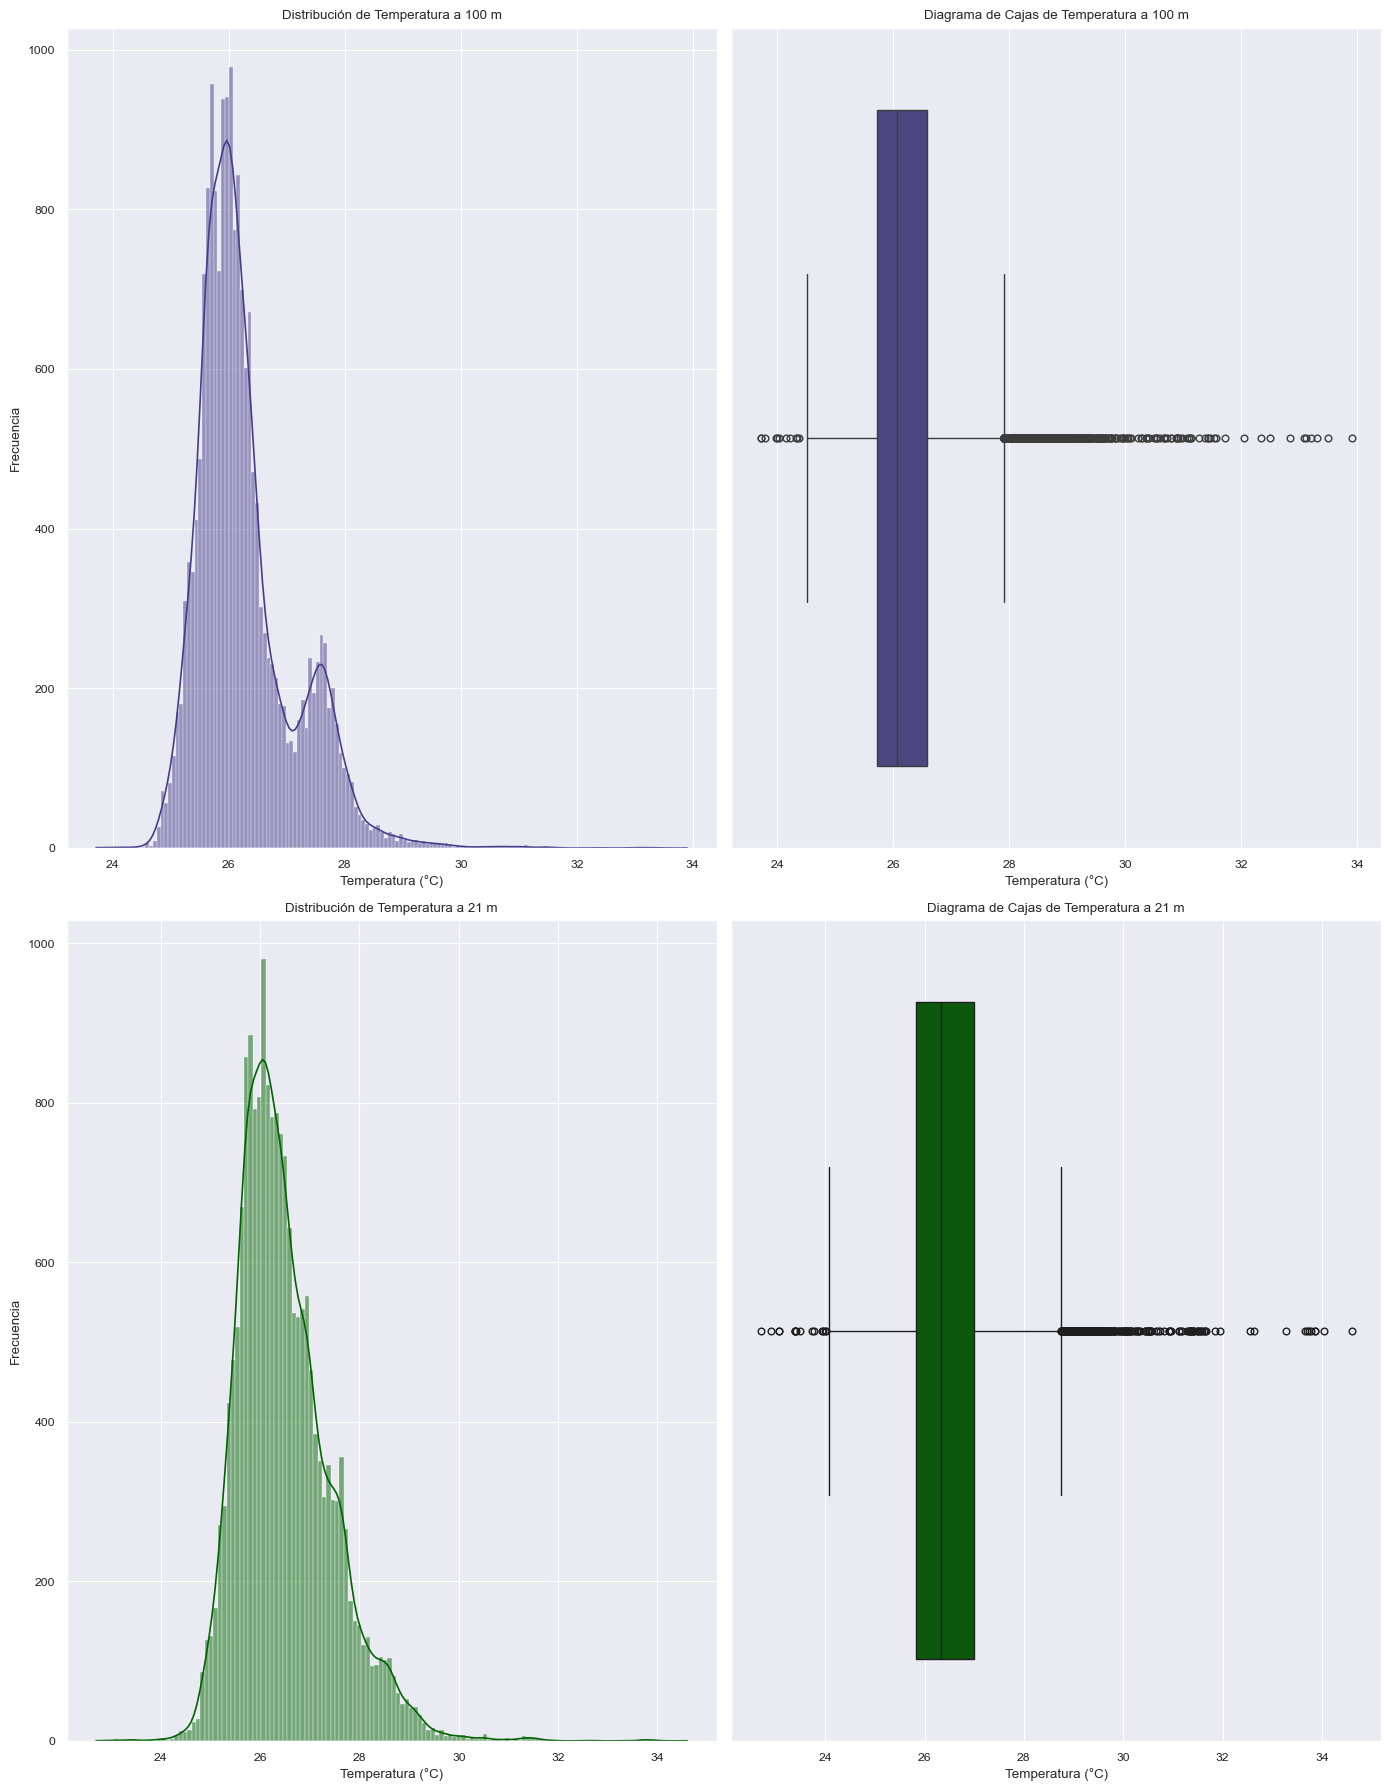

In [285]:
fig, axes = plt.subplots(2, 2, figsize=(14, 18))

# Configuración para Temp100m
sns.histplot(data['Temp100m'], kde=True, color='#473C8B', ax=axes[0, 0])
axes[0, 0].set_title('Distribución de Temperatura a 100 m')
axes[0, 0].set_xlabel('Temperatura (°C)')
axes[0, 0].set_ylabel('Frecuencia')

sns.boxplot(x=data['Temp100m'], color='#473C8B', ax=axes[0, 1], orient='h')
axes[0, 1].set_title('Diagrama de Cajas de Temperatura a 100 m')
axes[0, 1].set_xlabel('Temperatura (°C)')

# Configuración para Temp21m
sns.histplot(data['Temp21m'], kde=True, color='#006400', ax=axes[1, 0])
axes[1, 0].set_title('Distribución de Temperatura a 21 m')
axes[1, 0].set_xlabel('Temperatura (°C)')
axes[1, 0].set_ylabel('Frecuencia')

sns.boxplot(x=data['Temp21m'], color='#006400', ax=axes[1, 1], orient='h')
axes[1, 1].set_title('Diagrama de Cajas de Temperatura a 21 m')
axes[1, 1].set_xlabel('Temperatura (°C)')

plt.tight_layout()
plt.show()


## **Test de Dickey-Fuller**
En esta parte se realiza el planteamiento de hipótes de la prueba de `Dickey-Fuller` para verificar si cada una de las series de tiempo (correspondientes a cada variable) es estacionaria o no.

- **Hipótesis Nula (H₀)**: La serie de tiempo es NO estacionaria (tiene una raíz unitaria)

- **Hipótesis Alternativa (H₁)**: La serie de tiempo es estacionaria (no tiene una raíz unitaria)


In [286]:
resultados_adf = {}

# Realizar la prueba de Dickey-Fuller Aumentada para cada variable
for variable in data.columns[1:]:
    serie = data[variable].dropna()  
    adf_result = adfuller(data[variable].tolist())
    
    resultados_adf[variable] = {
        'Estadístico ADF': adf_result[0],
        'p-value': adf_result[1]
    }

resultados_adf_df = pd.DataFrame(resultados_adf).T
resultados_adf_df

Estadístico ADF       p-value
VelViento100m_1        -8.506317  1.200228e-13
VelViento100m_2        -8.530400  1.041451e-13
VelViento80m_1         -8.637280  5.546831e-14
VelViento80m_2         -8.686185  4.157365e-14
VelViento60m           -8.812831  1.970116e-14
VelViento40m           -8.973487  7.641693e-15
DirViento60m          -10.254852  4.388450e-18
DirViento100m         -11.337024  1.077418e-20
DirViento80m          -10.040999  1.496421e-17
Presion                -5.517637  1.909065e-06
Humedad               -12.517276  2.594758e-23
Temp100m               -8.252900  5.331596e-13
Temp21m               -12.971731  3.071135e-24